In [1]:
import warnings
import pandas as pd
import os
import utils

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

/var/folders/mp/6wd7514s0s1gfpl_csdmpfh80000gn/T/ipykernel_42936/2027364064.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#%xmode Standardsdf

In [3]:
'''raw_data = {}
for ext_id in ['EX1', 'EX2', 'EX3', 'EX4']:
    filename = f'test_data_{ext_id}.csv'
    raw_data[ext_id] = pd.read_csv(filename)''';

In [4]:
%%time

from datetime import datetime
from tqdm import tqdm
import os

test_data = {}

inp_filename = 'pi_pull_m6_2024-01-14.csv'
data_dir = 'data'

#date_cutoff = pd.to_datetime('2023-12-31')

inp_path = os.path.join(data_dir, inp_filename)
#raw_data = pd.read_csv(inp_path, nrows=N)

print(f'[INFO {datetime.now()}] Reading csv...')
raw_data = pd.read_csv(inp_path)

[INFO 2024-02-13 21:44:10.305104] Reading csv...
CPU times: user 51.7 s, sys: 1min 3s, total: 1min 55s
Wall time: 3min 54s


In [5]:
%%time

import preprocess

print(f'[INFO {datetime.now()}] Merging data...')
test_data = preprocess.merge_data_with_time(raw_data)

[INFO 2024-02-13 21:48:04.887692] Merging data...
CPU times: user 3min 30s, sys: 31.4 s, total: 4min 1s
Wall time: 4min 27s


In [6]:
print(f'[INFO {datetime.now()}] Processing data...')
for ext_id in tqdm(test_data.keys()):
    #filename = f'test_data_{ext_id}.csv'
    #test_data[ext_id] = pd.read_csv(filename)
    test_data[ext_id] = preprocess.process_column_names(test_data[ext_id], ext_id)
    test_data[ext_id] = preprocess.resample_and_fill(test_data[ext_id])

print(f'[INFO {datetime.now()}] ...complete.')

[INFO 2024-02-13 21:52:32.246943] Processing data...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.95s/it]

[INFO 2024-02-13 21:52:56.109202] ...complete.


In [7]:
test_data['EX1'].head()

,sample_gap_minutes,pressure,pressure_std_15S,velocity_screw_output,velocity_screw,temperature,thrust,current_screw,current_conveyor,velocity_conveyor,max_gap_24h
2023-07-17 16:06:15,0.533333,0.000000,116.731333,0.000000,6.952558e-310,0.000000,0.000000,0.00,0.000,6.952558e-310,1142.0
2023-07-17 16:07:45,1.516667,4313.717773,134.532581,27.810188,3.500000e+01,350.257812,50.520439,5.52,0.925,7.000000e+01,1142.0
2023-07-17 16:08:00,0.016667,4384.906250,114.737773,27.810188,3.500000e+01,350.257812,50.561836,5.52,0.935,7.000000e+01,1142.0
2023-07-17 16:08:15,2.450000,4352.253906,132.504091,27.810188,3.500000e+01,350.257812,50.634636,5.52,0.940,7.000000e+01,1142.0
2023-07-17 16:08:30,0.350000,4398.182617,145.890011,27.810188,3.500000e+01,350.257812,50.334274,5.52,0.935,7.000000e+01,1142.0


In [8]:
for key in test_data.keys():
    print(test_data[key].index.min(), test_data[key].index.max())

2023-07-17 16:06:15 2024-01-14 04:50:45
2023-07-17 16:06:15 2024-01-14 04:50:45
2023-09-20 07:20:45 2024-01-14 04:50:45
2023-07-17 16:06:15 2024-01-14 04:50:45


In [9]:
%%time

import pdb

def get_training_sample_conditions(
    df, 
    sample_gap_thresh=.2, 
    time_to_hazard_thresh = 75, 
    pressure_thresh=0
):
    train_conditions = (df['sample_gap_minutes'] < sample_gap_thresh) \
                         & (df['time_to_hazard'] < time_to_hazard_thresh) \
                             & (df['pressure'] > 500)
    return train_conditions

def get_target_condition(df, hours=6):
    return df['time_to_hazard'] < hours

pressure_threshold = 6000

from tqdm import tqdm

for ex_key in test_data.keys():
    test_data[ex_key]['hazard_state'] = (test_data[ex_key]['pressure'] >= pressure_threshold)
    test_data[ex_key]['time_to_hazard'] = utils.time_until_next_true(test_data[ex_key]['hazard_state'], debug=True)
    test_data[ex_key]['hazard_state'] = get_target_condition(test_data[ex_key])
    test_data[ex_key]['train_worthy'] = get_training_sample_conditions(test_data[ex_key])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 995346/995346 [00:00<00:00, 1390512.75it/s]

CPU times: user 2min 5s, sys: 383 ms, total: 2min 5s
Wall time: 2min 6s


In [10]:
ex1 = test_data['EX1']
ex2 = test_data['EX2']
ex3 = test_data['EX3']
ex4 = test_data['EX4']

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def balance_dataset(X, y, over_sample_ratio=0.1, under_sample_ratio=0.5, mode='custom'):
    """
    Balances the dataset by over-sampling the minority class and under-sampling the majority class.

    :param X: Feature set.
    :param y: Labels.
    :param over_sample_ratio: Ratio of the number of samples in the minority class after resampling
                              to the number of samples in the majority class before resampling.
    :param under_sample_ratio: Ratio of the number of samples in the majority class after resampling
                               to the number of samples in the minority class after over-sampling.

    :return: Balanced features and labels.
    """
    
    # Define the resampling strategy
    if mode == 'auto':
        over = SMOTE(sampling_strategy='auto')
        under = RandomUnderSampler(sampling_strategy='auto')
    else:
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy=0.4)

    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    
    # Transform the dataset
    X_balanced, y_balanced = pipeline.fit_resample(X, y)

    return X_balanced, y_balanced

In [17]:
train_test_set = pd.concat([test_data['EX1'], test_data['EX2'])
train_test_set = train_test_set[train_test_set['train_worthy']]

In [18]:
train_test_set.index.min(), train_test_set.index.max()

(Timestamp('2023-07-31 10:13:00'), Timestamp('2024-01-11 20:53:45'))

In [30]:
date_threshold = pd.to_datetime('12/20/2023')

train_df = train_test_set[train_test_set.index <= date_threshold]
test_df = train_test_set[train_test_set.index > date_threshold]

In [34]:
import pickle

from sklearn.metrics import accuracy_score, confusion_matrix

with open('svm_grid_search_ex12_6H_basevars_only_240212.pkl', 'rb') as f:
    grid_search = pickle.load(f)

model = grid_search.best_estimator_

# Assuming you have a dataset (X, y)
target_feature = 'hazard_state'

input_features = [
    'pressure',
    'velocity_screw_output',
    'velocity_screw',
    'temperature',
    'thrust',
    'current_screw',
    'current_conveyor',
    'velocity_conveyor'
]

X_test = test_df[input_features]
y_test = test_df[target_feature].values

probabilities = model.predict_proba(X_test)
predictions = model.predict(X_test)
    
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Visualize the confusion matrix
#plt.figure(figsize=(10, 7))
#sns.heatmap(conf_matrix, annot=True, fmt='g')
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')
#plt.title('Confusion Matrix')
#plt.show()
accuracy = accuracy_score(y_test, predictions)



In [49]:
for (tm, pt, pb, yt) in zip(test_df.index, test_df['pressure'].values, probabilities, y_test):
    print(tm, '|', pt, pb[1], int(yt))

2023-12-20 00:01:30 | 5299.8818359375 0.005524039772743154 0
2023-12-20 00:01:45 | 5308.7490234375 0.006704365164151318 0
2023-12-20 00:02:00 | 5214.8154296875 0.0054406569672695625 0
2023-12-20 00:02:30 | 5327.2431640625 0.009608637011458452 0
2023-12-20 00:03:00 | 5319.5068359375 0.008062432928301985 0
2023-12-20 00:03:15 | 5314.958984375 0.008294475777364732 0
2023-12-20 00:03:30 | 5390.53125 0.015234111061965669 0
2023-12-20 00:04:15 | 5432.64453125 0.024195134949204486 0
2023-12-20 00:04:45 | 5435.1943359375 0.027088915589379044 0
2023-12-20 00:05:15 | 5413.5185546875 0.011772407610876808 0
2023-12-20 00:06:00 | 5344.029296875 0.007480448796320289 0
2023-12-20 00:06:30 | 5341.427734375 0.007208800312905163 0
2023-12-20 00:08:00 | 5304.783203125 0.007985308720063401 0
2023-12-20 00:08:30 | 5372.1943359375 0.010688726995417518 0
2023-12-20 00:08:45 | 5309.6328125 0.005946618758833917 0
2023-12-20 00:09:00 | 5353.90234375 0.008470916034924777 0
2023-12-20 00:09:15 | 5332.8916015625 0

In [35]:
conf_matrix

array([[20830,   180],
       [ 3192,  2201]])

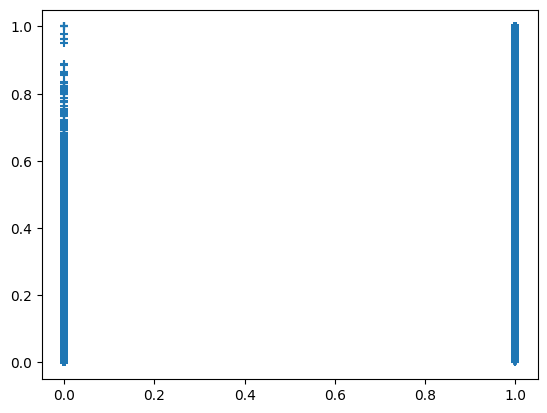

In [40]:
import matplotlib.pyplot as plt

plt.scatter(y_test, probabilities[:,1], marker='+')

In [5]:
grid_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma=0.1, probability=True))])

Accuracy: 0.134145
Confusion Matrix
[[    0 10663]
 [    0  1652]]
--------------------------------------


NameError: name 'time' is not defined

In [ ]:
%%time

import numpy as np
import pandas as pd

import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import seaborn as sns

import time

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(16, 32), max_iter=1000)
}

target_features = ['hazard_state']

input_features = [
    'pressure',
    'velocity_screw_output',
    'velocity_screw',
    'temperature',
    'thrust',
    'current_screw',
    'current_conveyor',
    'velocity_conveyor'
]



X_train = train_df[input_features].values
X_test = test_df[input_features].values

y_train = train_df[target_features].values
y_test = test_df[target_features].values

n_true = np.sum((y_train == 1))
n_false = np.sum((y_train == 0))
print(f'original true samples: {n_true}, original false samples: {n_false}')
print(y_train.sum() / len(y_train))
#X_train, y_train = balance_dataset(X_train, y_train, mode='notauto')
n_true = np.sum((y_train == 1))
n_false = np.sum((y_train == 0))
print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
print(y_train.sum() / len(y_train))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print(f'original true samples: {n_true}, original false samples: {n_false}')
print(y_train.sum() / len(y_train))

targ = '6h_to_hazard'
results = {targ: {}}
model_collection = {targ: {}}
        
for name, model in models.items():
    start_time = time.time()
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {model}')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)

    # Visualize the confusion matrix
    #plt.figure(figsize=(10, 7))
    #sns.heatmap(conf_matrix, annot=True, fmt='g')
    #plt.xlabel('Predicted labels')
    #plt.ylabel('True labels')
    #plt.title('Confusion Matrix')
    #plt.show()
    accuracy = accuracy_score(y_test, predictions)
    #cross_val = cross_val_score(model, X, y, cv=5)
    results[targ][name] = {'Accuracy': accuracy, #'Cross-Val Mean': np.mean(cross_val),
                          'Confusion_Matrix' : conf_matrix}
    model_collection[targ][name] = model
    
    
    print(results[targ][name])
    print('--------------------------------------')
    
    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')
    
#results_df = pd.DataFrame(results[targ]).T
#print(results_df)
print()
print()

# Convert results to DataFrame for better visualization
#results_df = pd.DataFrame(results).T
#print(results_df)
with open(f'classifier_models_6H_basevars_only_test2_240213.pkl', 'wb') as f:
    pickle.dump((model_collection, results), f)

original true samples: 11782, original false samples: 91383
0.1142053991179179
balanced true samples: 11782, balanced false samples: 91383
0.1142053991179179
original true samples: 11782, original false samples: 91383
0.1142053991179179

Current Time: 21:39:10
results for target: 6h_to_hazard, model: LogisticRegression()
{'Accuracy': 0.8727568006496143, 'Confusion_Matrix': array([[10662,     1],
       [ 1566,    86]])}
--------------------------------------
Run time: 0.00 minutes
Current Time: 21:39:10
--------------------------------------

Current Time: 21:39:10
results for target: 6h_to_hazard, model: RandomForestClassifier()
{'Accuracy': 0.8706455542021925, 'Confusion_Matrix': array([[10351,   312],
       [ 1281,   371]])}
--------------------------------------
Run time: 0.14 minutes
Current Time: 21:39:19
--------------------------------------

Current Time: 21:39:19
results for target: 6h_to_hazard, model: SVC(probability=True)


In [ ]:
%%time

import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import ShuffleSplit

target_features = 'hazard_state'

input_features = [
    'pressure',
    'velocity_screw_output',
    'velocity_screw',
    'temperature',
    'thrust',
    'current_screw',
    'current_conveyor',
    'velocity_conveyor'
]

X_train = train_df[input_features]
X_test = test_df[input_features]

y_train = train_df[target_features].values
y_test = test_df[target_features].values

#X_train, y_train = balance_dataset(X_train, y_train, mode='auto')

# Define the resampling strategy using SMOTE and RandomUnderSampler
#resampling_strategy = {
#    0: 20000,  # Undersample the majority class to 500 samples
#    1: 10000   # Oversample the minority class to 500 samples using SMOTE
#}



# Create a pipeline with scaling, resampling, and SVM classifier
svm_model = make_pipeline(StandardScaler(),
                          SVC(probability=True))

# Define grid of hyperparameters to search
#param_grid = {
#    'svc__C': [0.1, 1, 10],
#    'svc__gamma': [0.1, 0.01, 0.001],
#    'svc__kernel': ['rbf', 'linear']
#}

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.1, 0.01],
    'svc__kernel': ['rbf', 'linear']
}
# Perform grid search with a single train-test split (no cross-validation)
single_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
grid_search = GridSearchCV(
    svm_model, param_grid, scorin='precision', cv=single_split, n_jobs=-1, verbose=3)

# Train the SVM model with hyperparameter optimization
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters found by grid search:")
print(grid_search.best_params_)

# Predict probabilities on the test set using the best model
probabilities = grid_search.predict_proba(X_test)

print("\nProbabilities for each class:")
print(probabilities)

with open(f'svm_grid_search_ex12_6H_basevars_only_test2_240213.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

In [30]:
import sklearn

ModuleNotFoundError: No module named 'sklearn'

In [20]:
grid_search

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10], 'svc__gamma': [0.1, 0.01],
                         'svc__kernel': ['rbf', 'linear']},
             verbose=3)

In [19]:
with open(f'svm_grid_search_ex12_6H_basevars_only_240212.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

In [ ]:
%%time

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

import pickle
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

import time

# Assuming you have a dataset (X, y)
target_feature = 'hazard_state'

input_features = [
    'pressure',
    'velocity_screw_output',
    'velocity_screw',
    'temperature',
    'thrust',
    'current_screw',
    'current_conveyor',
    'velocity_conveyor'
]

X_train = train_df[input_features]
X_test = test_df[input_features]

y_train = train_df[target_feature].values
y_test = test_df[target_feature].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Train the model with the best parameters found by grid search
best_params = {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
best_model = SVC(**best_params)
best_model.fit(X_scaled, y_train)

model_file = 'best_model_params_svc_test.pkl'
# Save the trained model to a pickle file
with open(model_file, 'wb') as f:
    pickle.dump((best_model, scaler), f)

# Load the model from the pickle file
with open(model_file, 'rb') as f:
    loaded_model, loaded_scaler = pickle.load(f)

# Use the loaded model to make predictions
# Assuming you have new data for prediction (X_new)
#X_new = X[:10]  # Example: Use the first 10 samples for prediction
predictions = loaded_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

accuracy = accuracy_score(y_test, predictions)

print(f'Accuracy: {accuracy:02f}')
print('Confusion Matrix')
print(conf_matrix)
print('--------------------------------------')

duration = time.time() - start_time
print(f"Run time: {duration / 60:.2f} minutes")
print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
print('--------------------------------------')

# Print the predictions
print("Predictions:", predictions)

In [7]:
ex1 = test_data['EX1']
ex2 = test_data['EX2']
ex3 = test_data['EX3']
ex4 = test_data['EX4']

In [8]:
for ex_data in [ex1, ex2, ex3, ex4]:
    ex_data['train_worthy'] = get_training_sample_conditions(ex_data)



KeyError: 'time_to_hazard'

In [ ]:
combined_df = pd.concat([ex1, ex2, ex3, ex4], ignore_index=True)
combined_df.head()

<Axes: >

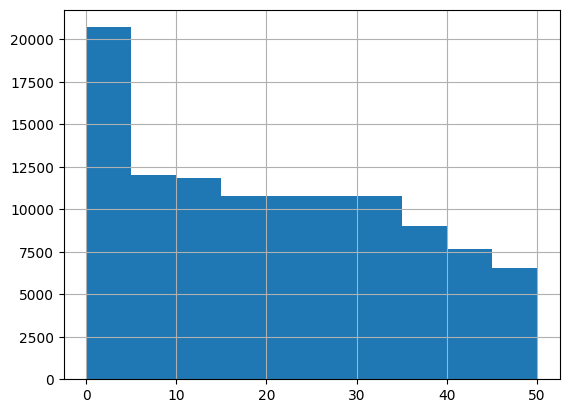

In [69]:
ex1['time_to_hazard'][ex1['time_to_hazard'] < 50].hist()

<Axes: >

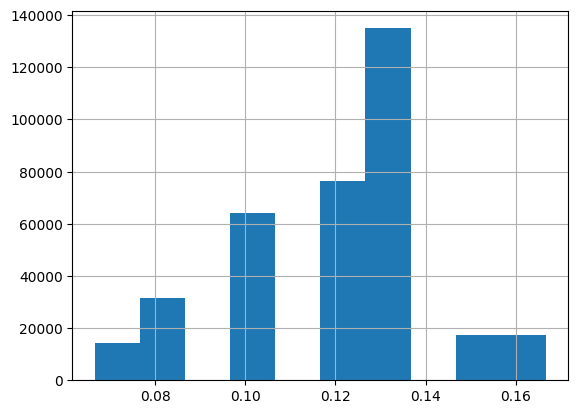

In [63]:
ex1['max_gap_24h'][ex1['max_gap_24h'] < .2].hist()

<Axes: >

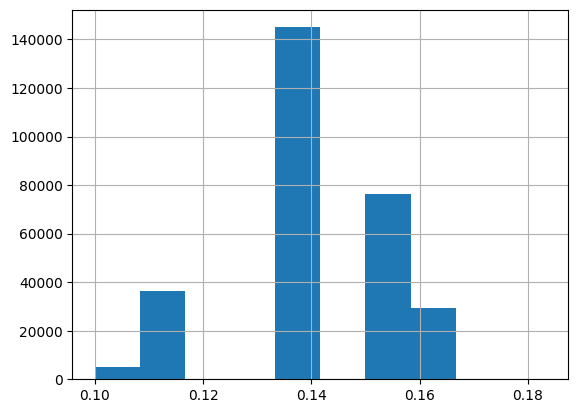

In [64]:
ex2['max_gap_24h'][ex2['max_gap_24h'] < .2].hist()

<Axes: >

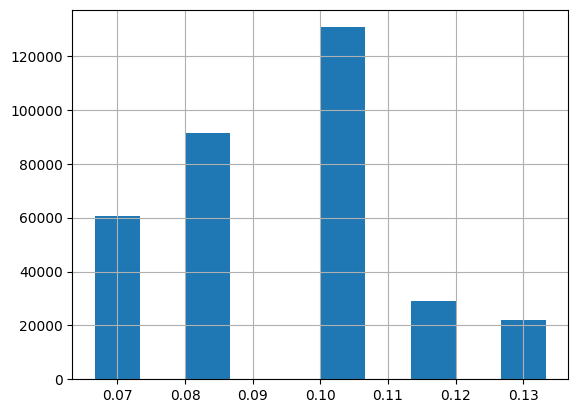

In [65]:
ex3['max_gap_24h'][ex3['max_gap_24h'] < .2].hist()

<Axes: >

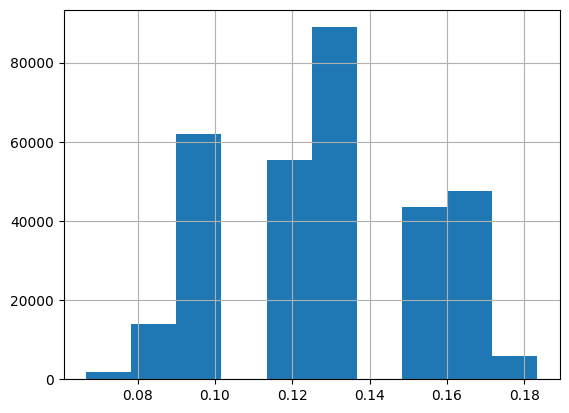

In [66]:
ex4['max_gap_24h'][ex4['max_gap_24h'] < .2].hist()

,sample_gap_minutes,pressure,pressure_var_15S,velocity_screw_output,velocity_screw,temperature,thrust,current_screw,current_conveyor,velocity_conveyor,max_gap_24h
0,0.366667,0.000000,11186.252248,0.000000,6.952558e-310,0.000000,0.000000,0.000,0.00,6.952558e-310,0.366667
1,66.983333,4577.089844,13183.557664,29.771286,2.500000e+01,340.960938,66.328491,5.560,0.96,7.500000e+01,66.983333
2,0.033333,4577.028320,6861.397940,29.771286,2.500000e+01,340.960938,66.328491,5.505,0.96,7.500000e+01,66.983333
3,0.033333,4544.083984,10056.262897,29.771286,2.500000e+01,340.960938,66.238998,5.490,0.96,7.500000e+01,66.983333
4,0.033333,4434.654297,6733.734053,29.771286,2.500000e+01,340.960938,66.591705,5.515,0.96,7.500000e+01,66.983333


In [ ]:
input_conditions = (ex1['sample_gap_minutes'] < .2) & (ex1[]) & ()

In [ ]:


def get_taget_condition(df, hours=6):
    return df['time_to_hazard'] < hours

pressure_threshold = 6000

from tqdm import tqdm

for ex_key in test_data.keys():
    test_data[ex_key]['hazard_state'] = (test_data[ex_key]['pressure'] >= pressure_threshold)
    test_data[ex_key]['time_to_hazard'] = utils.time_until_next_true(test_data[ex_key]['hazard_state'], debug=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390469/390469 [00:00<00:00, 1304668.93it/s]


In [52]:
import matplotlib.pyplot as plt

def plot_dual_axis(
    series1, series2, 
    xlabel='', ylabel1='', ylabel2='', title='',
    thresh1=None, thresh2=None, 
    alpha=0.6, rotate_x=45, ylims1=(4000, 7000)
):
    fig, ax1 = plt.subplots()

    ax1.plot(series1.index, series1.values, color='tab:blue', linestyle=linestyle, marker=)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color='tab:blue')
    if thresh1:
        ax1.axhline(y=thresh1, color='g', linestyle='--', alpha=alpha)
    if ylims1:
        ax1.set_ylim(*ylims1)

    ax2 = ax1.twinx()
    ax2.plot(series2.index, series2.values, color='tab:red')
    ax2.set_ylabel(ylabel2, color='tab:red')
    if thresh2:
        ax1.axhline(y=thresh2, color='g', linestyle='--', alpha=alpha)

    if rotate_x:
        print('here')
        #ax = plt.gca()
        ax1.tick_params(axis='x', rotation=rotate_x)

    plt.title(title)
    plt.show()

In [20]:
tmp.head()

,sample_gap_minutes,pressure,pressure_var_15S,velocity_screw_output,velocity_screw,temperature,thrust,current_screw,current_conveyor,velocity_conveyor,max_gap_24h,hazard_state,time_to_hazard
timestamp,,,,,,,,,,,,,
2023-11-21 07:56:00,0.033333,4537.110352,12640.760552,23.787582,25.0,327.941406,41.843170,2.835,0.96,65.0,0.133333,False,49.995833
2023-11-21 07:56:15,0.016667,4528.438477,15581.049199,23.787582,25.0,327.941406,41.996964,2.835,0.96,65.0,0.133333,False,49.991667
2023-11-21 07:56:30,0.033333,4591.853516,11605.902153,23.787582,25.0,327.941406,41.894417,2.835,0.96,65.0,0.133333,False,49.987500
2023-11-21 07:56:45,0.050000,4587.243164,16611.829365,23.787582,25.0,327.941406,41.911758,2.835,0.96,65.0,0.133333,False,49.983333
2023-11-21 07:57:00,0.033333,4559.621094,12781.668121,23.787582,25.0,327.941406,42.080063,2.835,0.96,65.0,0.133333,False,49.979167


here


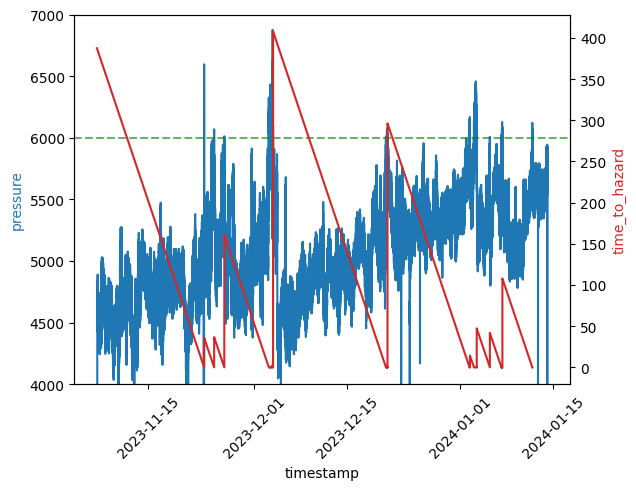

In [68]:
ext = 'EX1'

#conditions = (test_data[ext]['time_to_hazard'] < 50) #& (test_data[ext].index >= pd.to_datetime('11/01/2023')) & (test_data[ext].index < pd.to_datetime('1/25/2024'))

#tmp = test_data[ext][conditions]

plot_dual_axis(
    ex1['pressure'], ex1['time_to_hazard'],
    xlabel='timestamp', ylabel1='pressure', ylabel2='time_to_hazard',
    thresh1=6000
)

here


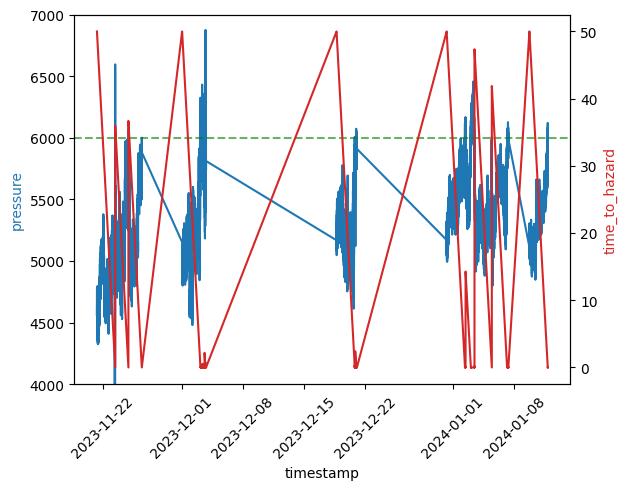

In [58]:
ext = 'EX1'

conditions = (test_data[ext]['time_to_hazard'] < 50) #& (test_data[ext].index >= pd.to_datetime('11/01/2023')) & (test_data[ext].index < pd.to_datetime('1/25/2024'))

tmp = test_data[ext][conditions]

plot_dual_axis(
    tmp['pressure'], tmp['time_to_hazard'],
    xlabel='timestamp', ylabel1='pressure', ylabel2='time_to_hazard',
    thresh1=6000
)

In [15]:
ex1_data.head(10)

,sample_gap_minutes,pressure,pressure_var_15S,velocity_screw_output,velocity_screw,temperature,thrust,current_screw,current_conveyor,velocity_conveyor
timestamp,,,,,,,,,,
2023-11-07 06:30:00,0.366667,0.000000,11186.252248,0.000000,6.952558e-310,0.000000,0.000000,0.000,0.00,6.952558e-310
2023-11-07 07:37:00,66.983333,4577.089844,13183.557664,29.771286,2.500000e+01,340.960938,66.328491,5.560,0.96,7.500000e+01
2023-11-07 07:37:15,0.033333,4577.028320,6861.397940,29.771286,2.500000e+01,340.960938,66.328491,5.505,0.96,7.500000e+01
2023-11-07 07:37:30,0.033333,4544.083984,10056.262897,29.771286,2.500000e+01,340.960938,66.238998,5.490,0.96,7.500000e+01
2023-11-07 07:37:45,0.033333,4434.654297,6733.734053,29.771286,2.500000e+01,340.960938,66.591705,5.515,0.96,7.500000e+01
2023-11-07 07:38:00,0.016667,4527.847656,14465.765605,29.771286,2.500000e+01,340.960938,66.423447,5.505,0.96,7.500000e+01
2023-11-07 07:38:15,0.050000,4476.000000,18864.120639,29.771286,2.500000e+01,340.960938,66.423447,5.505,0.96,7.500000e+01
2023-11-07 07:38:30,0.050000,4506.056641,9972.546850,29.771286,2.500000e+01,340.960938,66.051491,5.510,0.96,7.500000e+01
2023-11-07 07:38:45,0.016667,4660.917969,9419.899597,29.771286,2.500000e+01,340.960938,66.138000,5.510,0.96,7.500000e+01


In [5]:
test_data['EX1'].head()

,sample_gap_minutes,pressure,pressure_var_15S,velocity_screw_output,velocity_screw,temperature,thrust,current_screw,current_conveyor,velocity_conveyor
timestamp,,,,,,,,,,
2023-11-01 00:00:00,0.016667,5317.330078,12332.634222,NaN,NaN,NaN,70.513382,5.530,NaN,NaN
2023-11-01 00:00:15,0.016667,5329.744141,15331.538675,NaN,NaN,NaN,70.937973,5.515,NaN,NaN
2023-11-01 00:00:30,0.016667,5331.998047,15352.713859,NaN,NaN,NaN,70.486145,5.520,NaN,NaN
2023-11-01 00:00:45,0.016667,5251.179688,22646.594443,NaN,NaN,NaN,70.533646,5.515,NaN,NaN
2023-11-01 00:01:00,0.016667,5230.289062,10630.074085,NaN,NaN,NaN,70.695412,5.525,0.96,NaN


In [6]:
tmp = test_data['EX1']

tmp = tmp.dropna()
print(tmp.shape)
tmp.head()

(391284, 10)


,sample_gap_minutes,pressure,pressure_var_15S,velocity_screw_output,velocity_screw,temperature,thrust,current_screw,current_conveyor,velocity_conveyor
timestamp,,,,,,,,,,
2023-11-07 06:30:00,0.208333,0.0,11186.252248,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310
2023-11-07 06:30:15,0.208333,0.0,11186.252248,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310
2023-11-07 06:30:30,0.208333,0.0,11186.252248,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310
2023-11-07 06:30:45,0.208333,0.0,11186.252248,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310
2023-11-07 06:31:00,0.208333,0.0,11186.252248,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310


In [7]:
tmp = tmp[tmp['pressure'] > 0]

In [8]:
tmp.head()

,sample_gap_minutes,pressure,pressure_var_15S,velocity_screw_output,velocity_screw,temperature,thrust,current_screw,current_conveyor,velocity_conveyor
timestamp,,,,,,,,,,
2023-11-07 07:37:00,0.025000,4577.089844,13183.557664,29.771286,25.0,340.960938,66.328491,5.560,0.96,75.0
2023-11-07 07:37:15,0.016667,4577.028320,6861.397940,29.771286,25.0,340.960938,66.328491,5.505,0.96,75.0
2023-11-07 07:37:30,0.016667,4544.083984,10056.262897,29.771286,25.0,340.960938,66.238998,5.490,0.96,75.0
2023-11-07 07:37:45,0.016667,4434.654297,6733.734053,29.771286,25.0,340.960938,66.591705,5.515,0.96,75.0
2023-11-07 07:38:00,0.016667,4527.847656,14465.765605,29.771286,25.0,340.960938,66.423447,5.505,0.96,75.0


In [6]:
for ext_id in ['EX1', 'EX2', 'EX3', 'EX4']:
    print(ext_id)
    print(test_data[ext_id].notnull().sum())
    print()

EX1
sample_gap_minutes       5190829
timestamp                5190829
pressure                 4763152
pressure_var_15S         4763136
velocity_screw_output        512
velocity_screw                12
temperature                11649
thrust                   1621062
current_screw             474532
current_conveyor          543964
velocity_conveyor              9
dtype: int64

EX2
sample_gap_minutes       4334329
timestamp                4334329
pressure                 3895716
pressure_var_15S         3895646
velocity_screw_output         18
velocity_screw              1605
temperature                 2834
thrust                   1266539
current_screw             610573
current_conveyor           12686
velocity_conveyor             11
dtype: int64

EX3
sample_gap_minutes       5257688
timestamp                5257688
pressure                 4324425
pressure_var_15S         4324390
velocity_screw_output         10
velocity_screw              1173
temperature                  238
thr

In [7]:
test_data['EX1'].head(50)

,sample_gap_minutes,timestamp,pressure,pressure_var_15S,velocity_screw_output,velocity_screw,temperature,thrust,current_screw,current_conveyor,velocity_conveyor
0,0.016667,2023-11-01 00:00:00,5345.927734,15600.207309,NaN,NaN,NaN,70.842331,5.53,NaN,NaN
1,0.016667,2023-11-01 00:00:01,5182.835938,13857.769995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.016667,2023-11-01 00:00:02,5361.330078,14817.719224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.016667,2023-11-01 00:00:03,5216.503906,14088.264520,NaN,NaN,NaN,69.914169,NaN,NaN,NaN
4,0.016667,2023-11-01 00:00:04,5182.966797,13298.300299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.016667,2023-11-01 00:00:05,5239.525391,9755.322737,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.033333,2023-11-01 00:00:07,5317.330078,10363.340019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.016667,2023-11-01 00:00:08,5230.468750,7617.024509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.016667,2023-11-01 00:00:09,5419.757812,9620.468067,NaN,NaN,NaN,70.851944,5.51,NaN,NaN
9,0.016667,2023-11-01 00:00:10,5187.775391,9906.567737,NaN,NaN,NaN,70.184433,NaN,NaN,NaN


In [5]:
import pickle

print(default_column_mapping)

NameError: name 'default_column_mapping' is not defined

In [5]:
import pickle
with open('end2end_labels_map_2.pkl', 'rb') as f:
    default_column_mapping = pickle.load(f)
print(default_column_mapping)

{'EX1': {'PT_5347.PV': 'pressure', 'ST_5347.PV': 'velocity_screw_output', 'SIC_5345.OUT': 'velocity_screw', 'TT_5347.PV': 'temperature', 'WT_5347.PV': 'thrust', 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV': 'current_screw', 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV': 'current_conveyor', 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT': 'velocity_conveyor', 'Unnamed: 0': 'timestamp'}, 'EX2': {'PT_5352.PV': 'pressure', 'SIC_5350.OUT': 'velocity_screw_output', 'ST_5352.PV': 'velocity_screw', 'TT_5352.PV': 'temperature', 'WT_5352.PV': 'thrust', 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV': 'current_screw', 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV': 'current_conveyor', 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT': 'velocity_conveyor', 'Unnamed: 0': 'timestamp'}, 'EX3': {'PT_5357.PV': 'pressure', 'SIC_5355.OUT': 'velocity_screw_output', 'ST_5357.PV': 'velocity_screw', 'TT_5357.PV': 'temperature', 'WT_5357.PV':

In [12]:
with open('end2end_labels_map.pkl', 'rb') as f:
    default_column_mapping = pickle.load(f)

for key in default_column_mapping:
    default_column_mapping[key]['Unnamed: 0'] = 'timestamp'

with open('end2end_labels_map_2.pkl', 'wb') as f:
    pickle.dump(default_column_mapping, f)

In [14]:
test_data['EX2'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334329 entries, 0 to 4334328
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   sample_gap_minutes     float64
 1   timestamp              object 
 2   pressure               float64
 3   pressure_var_15S       float64
 4   velocity_screw_output  float64
 5   velocity_screw         float64
 6   temperature            float64
 7   thrust                 float64
 8   current_screw          float64
 9   current_conveyor       float64
 10  velocity_conveyor      float64
dtypes: float64(10), object(1)
memory usage: 363.8+ MB


In [12]:
(test_data['EX4'].sample_gap_minutes > .15).sum()

99

In [5]:
import pickle

def get_keys_for_columns(column_map):
    result = {}
    for key, values in column_map.items():
        for value in values:
            result[value] = key
    return result

with open('end2end_labels_map.pkl', 'rb') as f:
    default_column_mapping = pickle.load(f)

def merge_data_with_time(
    df, 
    redundancy_func='max', base_sample_period='15S', resample_rate=None, resample_func='median',
    verbose=False, get_series_list=False, column_map=default_column_mapping
):
    """
    Merge data columns with their corresponding time columns in a DataFrame.

    :param df: pandas DataFrame with data and time columns
    :param resample_rate: time period for resampling (e.g., '1H' for 1 hour)
    :param resample_func: aggregation function (e.g., 'mean', 'sum', 'max')
    :return: pandas DataFrame after merging
    """

    raw_series_list = []
    processed_series_lists = { 
        key: [] for key in ['EX1', 'EX2', 'EX3', 'EX4'] 
    }
    merged_dfs = { 
            key: None for key in ['EX1', 'EX2', 'EX3', 'EX4'] 
        }
    
    column2extruder_map = get_keys_for_columns(column_map)

    for column in df.columns:
        if not column.endswith('.TIME'):
            time_column = column + '.TIME'
            if time_column in df.columns:
                if column in column2extruder_map.keys():
                    extruder_id = column2extruder_map[column]
                else:
                    print(f'[WARNING] no entry for {column} in mapping, skipping.')
                    continue

                series = pd.Series(df[column].values, 
                    index=pd.to_datetime(df[time_column]), 
                    name=column
                )
                raw_series_list.append(series)
                series = series[series.index.notnull()]
                series.sort_index(inplace=True)
                if 'PT' in column:
                    local_variance = series.rolling(base_sample_period).var()
                    local_variance.name = f'{column}_{base_sample_period}_var'
                if redundancy_func == 'max':
                    series = series.groupby(level=0).max()
                elif redundancy_func == 'median':
                    series = series.groupby(level=0).median()
                else:
                    series = series.groupby(level=0).mean()

                if verbose:
                    print(series.head())
                processed_series_lists[extruder_id].append(series)
                
                if 'PT' in column:
                    local_variance = local_variance.loc[series.index].groupby(level=0).max()
                    processed_series_lists[extruder_id].append(local_variance)
    
    for extruder_id in merged_dfs.keys():
        merged_dfs[extruder_id] = pd.concat(processed_series_lists[extruder_id], axis=1, join='outer')
        merged_dfs[extruder_id]['sample_gap_minutes'] = \
            merged_dfs[extruder_id].index.to_series().diff().apply(lambda x: x.total_seconds() / 60)
        
    if resample_rate:
        merged_df = merged_df.resample(resample_rate).apply(resample_func)
    
    if get_series_list:
        return merged_dfs, raw_series_list
    else:
        return merged_dfs


In [6]:
%%time
extruder_data = utils.merge_data_with_time(raw_data)
#extruder_data = merge_data_with_time(raw_data)

CPU times: user 3min 43s, sys: 1min 4s, total: 4min 48s
Wall time: 5min 12s


In [9]:
extruder_data['EX1'].index.min(), extruder_data['EX1'].index.max()

(Timestamp('2023-07-16 04:50:50'), Timestamp('2024-01-14 04:50:49'))

In [10]:
test_extruder_data = {}

for key in extruder_data:
    test_extruder_data[key] = extruder_data[key][extruder_data[key].index >= pd.to_datetime('11/1/23')]

    test_extruder_data[key].to_csv(f'test_data_{key}.csv')

In [15]:
for key in test_extruder_data:
    print(key)
    print(test_extruder_data[key].notnull().sum())

EX1
PT_5347.PV                                                   4763152
PT_5347.PV_15S_var                                           4763136
ST_5347.PV                                                       512
SIC_5345.OUT                                                      12
TT_5347.PV                                                     11649
WT_5347.PV                                                   1621062
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV       474532
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV       543964
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT          9
sample_gap_minutes                                           5190829
dtype: int64
EX2
PT_5352.PV                                                   3895716
PT_5352.PV_15S_var                                           3895646
SIC_5350.OUT                                                      18
ST_5352.PV                                                      1605
TT_5352.PV   

In [ ]:
del raw_data, extruder_data

In [36]:
extruder_data['EX1'].head(2)

,PT_5347.PV,PT_5347.PV,ST_5347.PV,SIC_5345.OUT,TT_5347.PV,WT_5347.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,sample_gap_minutes
2023-07-16 04:50:50,4070.291016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 04:50:51,3941.896484,8242.577827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016667


In [37]:
extruder_data['EX2'].head(2)

,PT_5352.PV,PT_5352.PV,SIC_5350.OUT,ST_5352.PV,TT_5352.PV,WT_5352.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT,sample_gap_minutes
2023-07-16 04:50:50,3206.291016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 04:50:52,3055.000000,11444.485704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033333


In [38]:
extruder_data['EX3'].head(2)

,PT_5357.PV,PT_5357.PV,SIC_5355.OUT,ST_5357.PV,TT_5357.PV,WT_5357.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5355.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5415.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5415.OUT,sample_gap_minutes
2023-07-17 15:36:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN
2023-07-17 15:36:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,NaN,0.016667


In [39]:
extruder_data['EX4'].head(2)

,PT_5362.PV,PT_5362.PV,SIC_5360.OUT,ST_5362.PV,TT_5362.PV,WT_5362.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT,sample_gap_minutes
2023-07-16 04:50:50,1799.374023,NaN,NaN,NaN,NaN,37.652023,NaN,1.07,NaN,NaN
2023-07-16 04:50:51,1746.228516,1412.2225,NaN,NaN,NaN,36.429214,NaN,NaN,NaN,0.016667


In [12]:
extruder_data['EX1'].shape

(12895531, 10)

In [33]:
test = extruder_data['EX1'].iloc[3000000:6000000]

In [34]:
# Assuming 'data_series' is your pandas data series
# Set the window size in hours
window_size_hours = 24

# Convert window size to a Timedelta object
window_size_timedelta = pd.Timedelta(hours=window_size_hours)

test['max_gap_24h'] = test['sample_gap_minutes'].rolling(window=window_size_timedelta).max()

<Axes: >

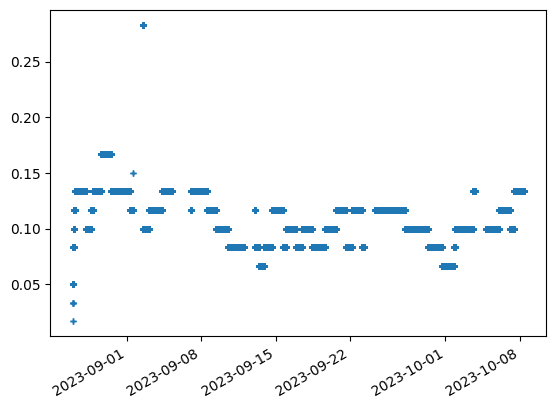

In [35]:
test[test['max_gap_24h'] < 0.3]['max_gap_24h'].plot(marker='+', markersize='5', linestyle='')

In [6]:
extruder_data['EX1'].head()

,PT_5347.PV,PT_5347.PV,ST_5347.PV,SIC_5345.OUT,TT_5347.PV,WT_5347.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,sample_gap_minutes
2023-07-16 04:50:50,4070.291016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 04:50:51,3941.896484,8242.577827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016667
2023-07-16 04:50:52,4167.226562,12775.883335,NaN,NaN,NaN,NaN,NaN,0.94,NaN,0.016667
2023-07-16 04:50:53,3930.353516,12706.657032,NaN,NaN,NaN,49.097092,NaN,0.98,NaN,0.016667
2023-07-16 04:50:54,4192.916016,15006.329724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016667


In [ ]:
extruder_data.keys()

In [ ]:
len(extruder_data['EX1']), extruder_data['EX1'].shape

In [ ]:
extruder_data['EX1'].isnull().sum() / extruder_data['EX1'].shape[0]

In [ ]:
extruder_data['EX2'].isnull().sum() / extruder_data['EX2'].shape[0]

In [ ]:
extruder_data['EX1'][
    (extruder_data['EX1'].sample_gap_minutes > 3) & (extruder_data['EX1'].sample_gap_minutes < 4)
].sample_gap_minutes.plot(marker='o', linestyle='')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_data_per_hour(data, date):
    # Ensure that the index is a datetime index
    data.index = pd.to_datetime(data.index)
    
    # Extract date if date is a timestamp
    if isinstance(date, pd.Timestamp):
        date = date.date()
    elif isinstance(date, str):
        date = pd.to_datetime(date).date()
    else:
        raise ValueError("Invalid date format. Please provide a date string or a pandas Timestamp.")

    # Filter data for the specified date
    data_date = data[data.index.date == date]

    # Find hours with data
    hours_with_data = data_date.index.hour.unique()

    if len(hours_with_data) == 0:
        print(f"No data available for the specified date {date}")
        return

    # Plot the data for each hour separately
    for hour in hours_with_data:
        data_hour = data_date[data_date.index.hour == hour]
        if data_hour.notnull().sum() > 5:
            plt.plot(data_hour.index, data_hour.values)

            plt.xlabel('Time')
            plt.ylabel('Data')
            plt.title(f'Data for {date} - Hour {hour}')
            plt.show()

# Example usage:
# Assume 'df' is your DataFrame or Series
# 'date' is the specific date you want to plot, it can be a string or a pandas Timestamp
# plot_data_per_hour(df, '2024-02-10')
# plot_data_per_hour(df, pd.Timestamp('2024-02-10'))

In [100]:
date_range_daily = pd.date_range(start=pd.to_datetime('10/01/2022'), end=pd.to_datetime('12/31/2022'), freq='D')
#print(date_range_daily)

for date in date_range_daily:
    plot_data_per_hour(extruder_data['EX1']['PT_5347.PV'], date)

No data available for the specified date 2022-10-01
No data available for the specified date 2022-10-02
No data available for the specified date 2022-10-03
No data available for the specified date 2022-10-04
No data available for the specified date 2022-10-05
No data available for the specified date 2022-10-06
No data available for the specified date 2022-10-07
No data available for the specified date 2022-10-08
No data available for the specified date 2022-10-09
No data available for the specified date 2022-10-10
No data available for the specified date 2022-10-11
No data available for the specified date 2022-10-12
No data available for the specified date 2022-10-13
No data available for the specified date 2022-10-14
No data available for the specified date 2022-10-15
No data available for the specified date 2022-10-16
No data available for the specified date 2022-10-17
No data available for the specified date 2022-10-18
No data available for the specified date 2022-10-19
No data avai

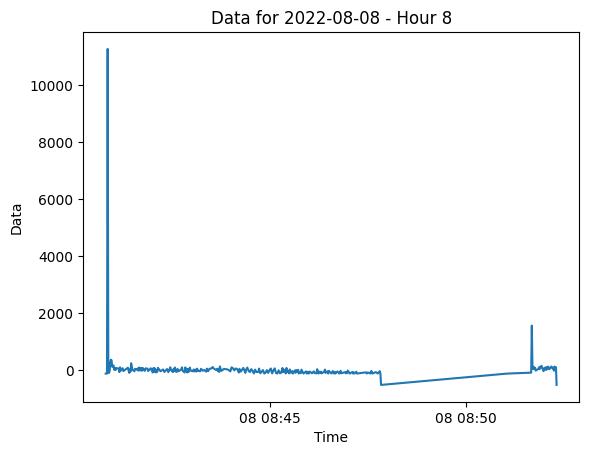

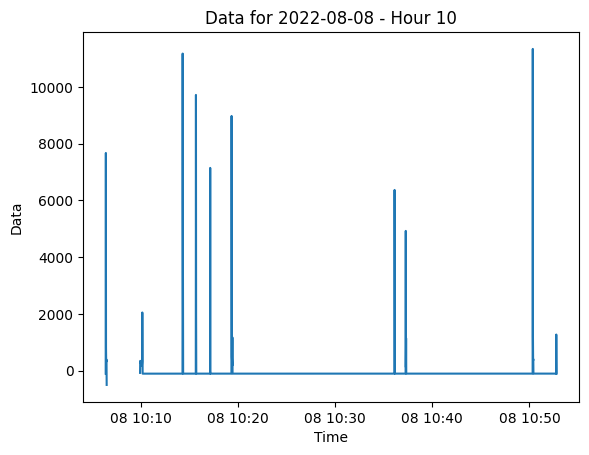

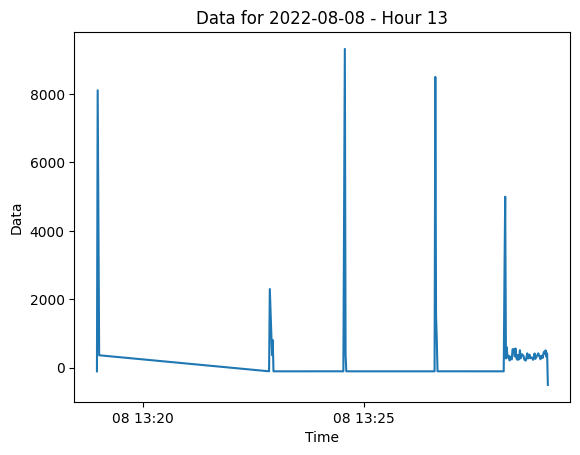

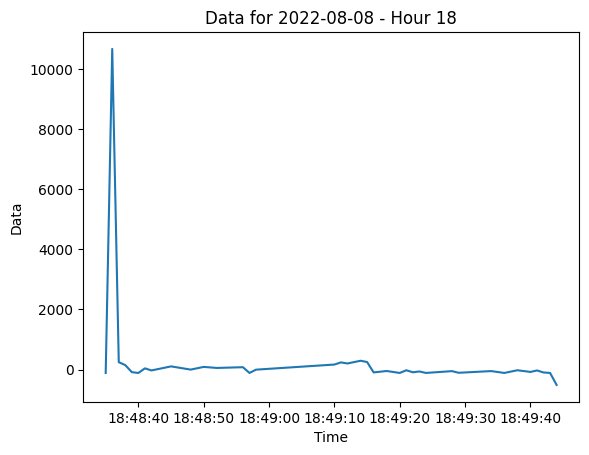

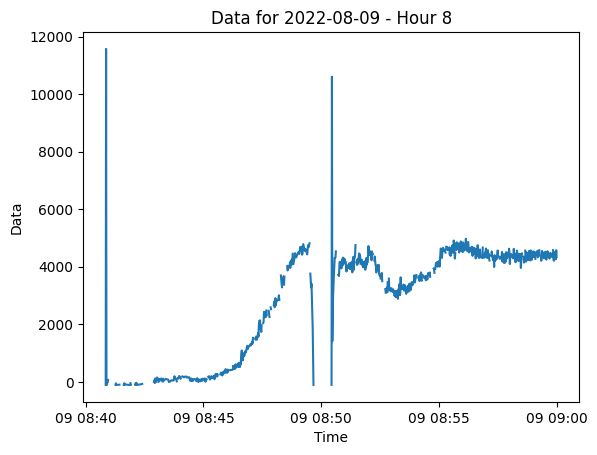

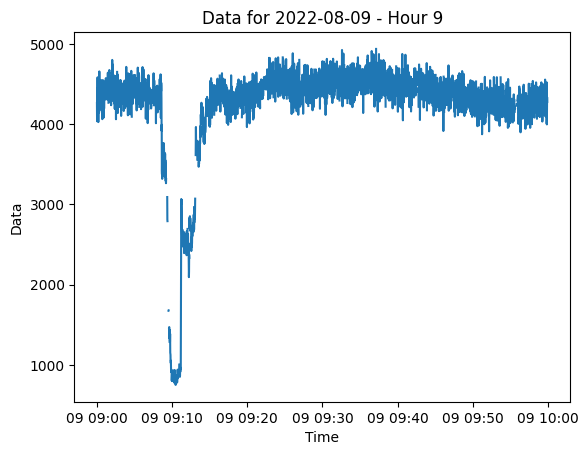

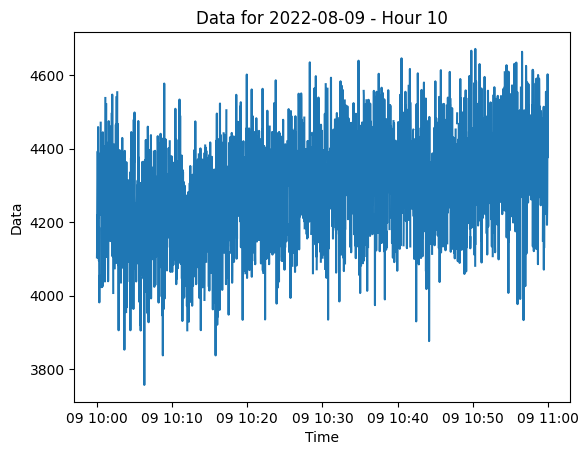

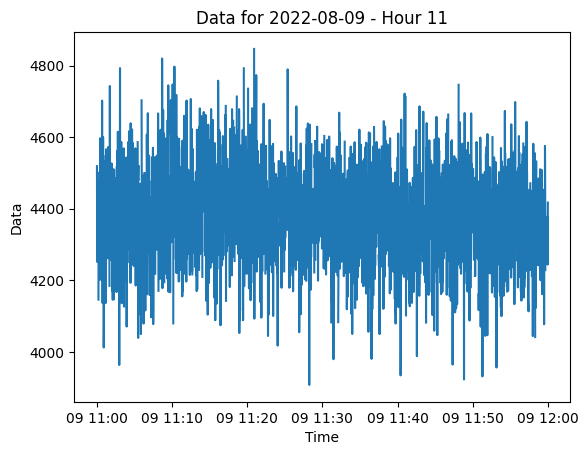

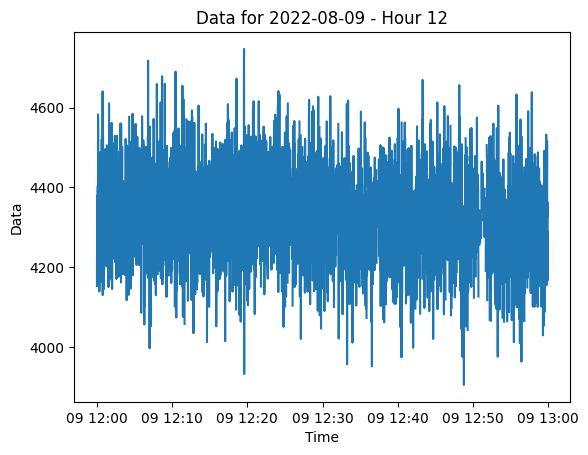

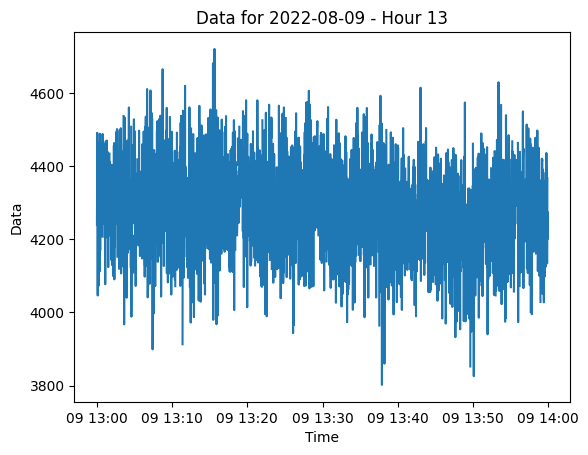

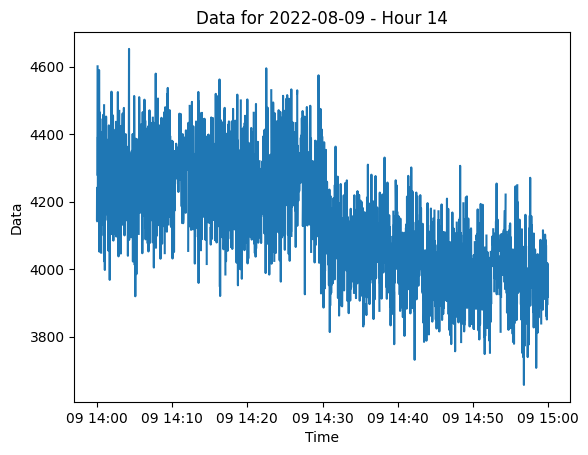

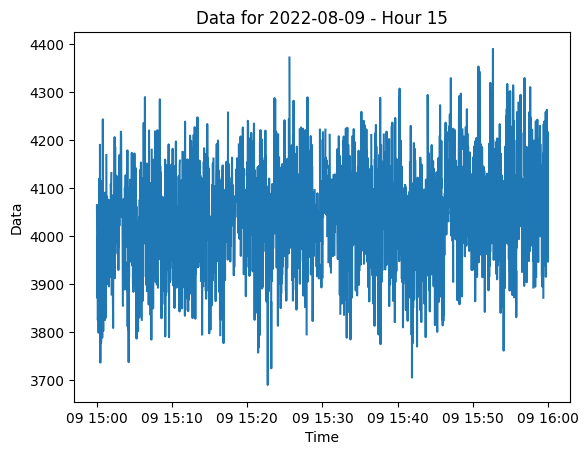

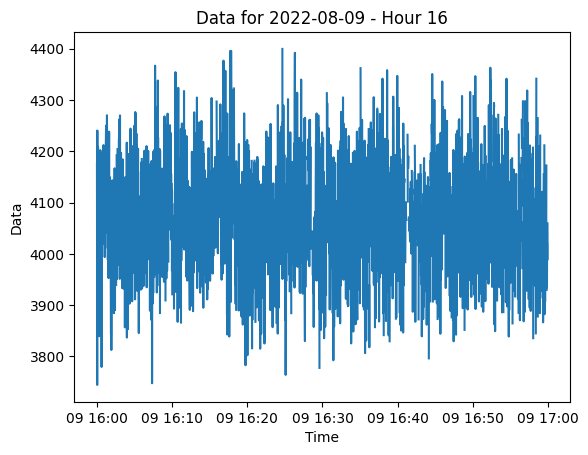

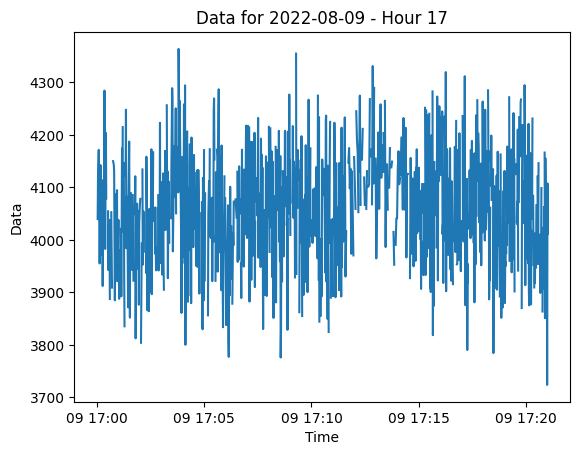

No data available for the specified date 2022-08-23
No data available for the specified date 2022-08-24
No data available for the specified date 2022-08-25
No data available for the specified date 2022-08-26
No data available for the specified date 2022-08-27
No data available for the specified date 2022-08-28
No data available for the specified date 2022-08-29
No data available for the specified date 2022-08-30
No data available for the specified date 2022-08-31
No data available for the specified date 2022-09-01
No data available for the specified date 2022-09-02
No data available for the specified date 2022-09-03
No data available for the specified date 2022-09-04
No data available for the specified date 2022-09-05
No data available for the specified date 2022-09-06
No data available for the specified date 2022-09-07
No data available for the specified date 2022-09-08
No data available for the specified date 2022-09-09
No data available for the specified date 2022-09-10
No data avai

In [99]:
date_range_daily = pd.date_range(start=pd.to_datetime('08/08/2022'), end=pd.to_datetime('09/30/2022'), freq='D')
#print(date_range_daily)

for date in date_range_daily:
    plot_data_per_hour(extruder_data['EX1']['PT_5347.PV'], date)

In [11]:
extruder_data['EX1'].iloc[5:50]

,PT_5347.PV,PT_5347.PV,ST_5347.PV,SIC_5345.OUT,TT_5347.PV,WT_5347.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,sample_gap_minutes
2023-07-16 04:50:55,4114.320312,15608.782937,NaN,NaN,NaN,NaN,NaN,0.96,NaN,0.016667
2023-07-16 04:50:56,NaN,NaN,NaN,NaN,NaN,48.470383,NaN,1.02,NaN,0.016667
2023-07-16 04:50:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.01,NaN,0.016667
2023-07-16 04:50:58,4143.152344,1580.832269,NaN,NaN,NaN,NaN,NaN,0.94,NaN,0.016667
2023-07-16 04:50:59,3986.996094,6904.586187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016667
2023-07-16 04:51:00,4165.197266,9437.735109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016667
2023-07-16 04:51:01,3943.230469,12314.987967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016667
2023-07-16 04:51:02,3945.251953,11853.351019,NaN,NaN,NaN,NaN,5.56,NaN,NaN,0.016667
2023-07-16 04:51:03,4138.650391,11617.930525,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.016667
2023-07-16 04:51:04,3923.732422,13964.209599,NaN,NaN,NaN,NaN,NaN,0.96,NaN,0.016667


In [40]:
for ext_id in ['EX1', 'EX2', 'EX3', 'EX4']:
    print(ext_id)
    print((extruder_data[ext_id].isnull().sum() / extruder_data[ext_id].shape[0]).astype(float))
    print()

EX1
PT_5347.PV                                                   1.060881e-01
PT_5347.PV                                                   1.077760e-01
ST_5347.PV                                                   9.998932e-01
SIC_5345.OUT                                                 9.999984e-01
TT_5347.PV                                                   9.975150e-01
WT_5347.PV                                                   6.578817e-01
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV      9.233254e-01
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV      8.023844e-01
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT    9.999979e-01
sample_gap_minutes                                           7.754624e-08
dtype: float64

EX2
PT_5352.PV                                                   1.205726e-01
PT_5352.PV                                                   1.256451e-01
SIC_5350.OUT                                                 9.999966e-01
ST_5352.PV    

In [10]:
import utils

time_indexed_data = utils.merge_data_with_time(raw_data)

In [12]:
time_indexed_data.head()

,PT_5347.PV_variance,PT_5347.PV,ST_5347.PV,SIC_5345.OUT,TT_5347.PV,WT_5347.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,PT_5352.PV_variance,PT_5352.PV,SIC_5350.OUT,ST_5352.PV,TT_5352.PV,WT_5352.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT,PT_5357.PV_variance,PT_5357.PV,SIC_5355.OUT,ST_5357.PV,TT_5357.PV,WT_5357.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5355.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5415.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5415.OUT,PT_5362.PV_variance,PT_5362.PV,SIC_5360.OUT,ST_5362.PV,TT_5362.PV,WT_5362.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT,sample_gap_minutes
2022-07-25 12:07:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18876.017305,3824.832031,NaN,NaN,NaN,36.616714,NaN,0.94,NaN,0.033333
2022-07-25 12:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9497.274905,3845.694336,NaN,NaN,NaN,36.791321,NaN,0.94,NaN,0.033333
2022-07-25 12:08:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8129.301857,3778.740234,NaN,NaN,NaN,36.674698,NaN,0.95,NaN,0.050000
2022-07-25 12:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8754.438056,3789.305664,NaN,NaN,NaN,36.663849,NaN,0.95,NaN,0.033333
2022-07-25 12:09:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9498.635162,3756.673828,NaN,NaN,NaN,36.587921,5.25,0.96,NaN,0.033333


In [16]:
time_indexed_data.isnull().sum() / time_indexed_data.shape[0]

PT_5347.PV_variance                                          0.986580
PT_5347.PV                                                   0.986531
ST_5347.PV                                                   0.999020
SIC_5345.OUT                                                 0.999926
TT_5347.PV                                                   0.997358
WT_5347.PV                                                   0.968968
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV      0.883699
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV      0.963660
PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT    0.999777
PT_5352.PV_variance                                          0.986183
PT_5352.PV                                                   0.986171
SIC_5350.OUT                                                 0.999950
ST_5352.PV                                                   0.997730
TT_5352.PV                                                   0.996056
WT_5352.PV          

In [19]:
test = time_indexed_data.columns[:]

Index(['PT_5347.PV_variance', 'PT_5347.PV', 'ST_5347.PV', 'SIC_5345.OUT',
       'TT_5347.PV', 'WT_5347.PV',
       'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV',
       'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV',
       'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT',
       'PT_5352.PV_variance'],
      dtype='object')

In [7]:
%%time

import utils
import os
import pandas as pd
from tqdm import tqdm

#from tqdm import tqdm

# takes about 2 minutes - 1/20/24

#inp_filename = 'EX1-6-month.csv'
data_dir = 'data'

field_mappings = {}
#time_
#ex_data = {}
#processed_data = {}
#merged_data = {}
#collected_series = {}

extruder_tmp = 'EX1'
data_dir = 'data/'
chunked_dir = data_dir + 'chunked/'

df_list = []
#df_list = []

for extruder in ['EX2', 'EX3', 'EX4']:
    compiled_df = []
    for (i, chunked_file) in tqdm(enumerate(os.listdir(chunked_dir))):
        if not '.csv' in chunked_file:
            continue
    
        print(f'completed {i} of {len(os.listdir(chunked_dir))}')
    
        filepath = os.path.join(data_dir, f'{extruder}-6-month.csv')
        keys_of_interest, time_keys, field_mapping, column_mapping, raw_fieldnames = utils.get_extruder_metadata(filepath)
        field_mappings[extruder], field_mappings[f'{extruder}_column_map'] = field_mapping, column_mapping
    
        ex_data = pd.read_csv(os.path.join(chunked_dir, chunked_file))
        #ex_data.to_csv(f'{extruder}_raw_data.csv}')
    
    
        merged_df, series_list = utils.merge_data_with_time(
            ex_data, 
            resample_rate='30S', resample_func='max', 
            verbose=False, get_series_list=True
        )
        
        for raw_colname in field_mappings[f'{extruder}_column_map'].keys():
            merged_df[field_mappings[extruder][raw_colname]] = merged_df[field_mappings[f'{extruder}_column_map'][raw_colname]]
        
        processed_colnames = list(field_mappings[extruder].values())
        processed_colnames.remove('Date and Time')
        merged_df = merged_df[processed_colnames + ['sample_gap_minutes']]
    
    #    merged_data[extruder] = merged_df
    
        processed_df = utils.preprocess_data(merged_df)
    
        #if compiled_df is None:
        #    compiled_df = processed_df
        #else:
        #    compiled_df = pd.merge(compiled_df, processed_df, left_index=True, right_index=True)
        df_list.append(processed_df)
    
    compiled_df = pd.concat(df_list).sort_index()
    
    compiled_df.to_csv(f'data/{extruder}_processed_18month.csv')
        
#    processed_data[extruder] = processed_df
#    collected_series[extruder] = series_list
    
#    for tk in time_keys:
#        ex_data[extruder][tk] = pd.to_datetime(ex_data[extruder][tk])


0it [00:00, ?it/s]

completed 0 of 70


1it [00:13, 13.17s/it]

completed 1 of 70


2it [00:18,  8.56s/it]

completed 2 of 70


3it [00:33, 11.66s/it]

completed 3 of 70


4it [00:48, 12.69s/it]

completed 4 of 70


5it [01:00, 12.40s/it]

completed 5 of 70


6it [01:06, 10.54s/it]

completed 6 of 70


7it [01:13,  9.23s/it]

completed 7 of 70


8it [01:19,  8.20s/it]

completed 8 of 70


9it [01:35, 10.79s/it]

completed 9 of 70


10it [01:44, 10.11s/it]

completed 10 of 70


11it [01:57, 11.05s/it]

completed 11 of 70


12it [02:07, 10.52s/it]

completed 12 of 70


13it [02:17, 10.56s/it]

completed 13 of 70


14it [02:23,  9.20s/it]

completed 14 of 70


15it [02:35,  9.95s/it]

completed 15 of 70


16it [02:49, 11.22s/it]

completed 16 of 70


17it [02:59, 10.89s/it]

completed 17 of 70


18it [03:07, 10.02s/it]

completed 18 of 70


19it [03:13,  8.83s/it]

completed 19 of 70


20it [03:23,  9.13s/it]

completed 20 of 70


21it [03:35, 10.09s/it]

completed 21 of 70


22it [03:44,  9.78s/it]

completed 22 of 70


23it [03:55,  9.97s/it]

completed 23 of 70


24it [04:05, 10.13s/it]

completed 24 of 70


25it [04:12,  9.11s/it]

completed 25 of 70


26it [04:21,  8.89s/it]

completed 26 of 70


27it [04:25,  7.67s/it]

completed 27 of 70


28it [04:31,  6.93s/it]

completed 28 of 70


29it [04:43,  8.57s/it]

completed 30 of 70


31it [04:52,  6.63s/it]

completed 31 of 70


32it [04:57,  6.26s/it]

completed 32 of 70


33it [05:07,  7.20s/it]

completed 33 of 70


34it [05:16,  7.73s/it]

completed 34 of 70


35it [05:26,  8.41s/it]

completed 35 of 70


36it [05:36,  8.87s/it]

completed 36 of 70


37it [05:48,  9.64s/it]

completed 37 of 70


38it [06:02, 10.91s/it]

completed 38 of 70


39it [06:16, 11.91s/it]

completed 39 of 70


40it [06:26, 11.44s/it]

completed 40 of 70


41it [06:40, 12.02s/it]

completed 41 of 70


42it [06:47, 10.71s/it]

completed 42 of 70


43it [07:02, 12.10s/it]

completed 43 of 70


44it [07:16, 12.55s/it]

completed 44 of 70


45it [07:26, 11.86s/it]

completed 45 of 70


46it [07:38, 11.83s/it]

completed 46 of 70


47it [07:46, 10.51s/it]

completed 47 of 70


48it [07:53,  9.47s/it]

completed 48 of 70


49it [07:57,  8.05s/it]

completed 49 of 70


50it [08:05,  8.00s/it]

completed 50 of 70


51it [08:06,  5.70s/it]

completed 51 of 70


52it [08:17,  7.40s/it]

completed 52 of 70


53it [08:27,  8.33s/it]

completed 53 of 70


54it [08:41,  9.79s/it]

completed 54 of 70


55it [08:50,  9.80s/it]

completed 55 of 70


56it [09:01, 10.06s/it]

completed 56 of 70


57it [09:13, 10.57s/it]

completed 57 of 70


58it [09:24, 10.63s/it]

completed 58 of 70


59it [09:30,  9.24s/it]

completed 59 of 70


60it [09:36,  8.27s/it]

completed 60 of 70


61it [09:49,  9.74s/it]

completed 61 of 70


62it [09:54,  8.43s/it]

completed 62 of 70


63it [10:00,  7.74s/it]

completed 63 of 70


64it [10:11,  8.65s/it]

completed 64 of 70


65it [10:16,  7.59s/it]

completed 65 of 70


66it [10:28,  8.72s/it]

completed 66 of 70


67it [10:33,  7.85s/it]

completed 67 of 70


68it [10:39,  7.30s/it]

completed 68 of 70


69it [10:47,  7.48s/it]

completed 69 of 70


70it [10:55,  9.36s/it]
0it [00:00, ?it/s]

completed 0 of 70


1it [00:12, 12.42s/it]

completed 1 of 70


2it [00:17,  8.29s/it]

completed 2 of 70


3it [00:35, 12.48s/it]

completed 3 of 70


4it [00:47, 12.55s/it]

completed 4 of 70


5it [00:59, 12.30s/it]

completed 5 of 70


6it [01:06, 10.35s/it]

completed 6 of 70


7it [01:13,  9.16s/it]

completed 7 of 70


8it [01:19,  8.21s/it]

completed 8 of 70


9it [01:35, 10.81s/it]

completed 9 of 70


10it [01:43,  9.83s/it]

completed 10 of 70


11it [01:55, 10.63s/it]

completed 11 of 70


12it [02:05, 10.28s/it]

completed 12 of 70


13it [02:15, 10.19s/it]

completed 13 of 70


14it [02:21,  8.99s/it]

completed 14 of 70


15it [02:33,  9.85s/it]

completed 15 of 70


16it [02:48, 11.48s/it]

completed 16 of 70


17it [02:58, 11.00s/it]

completed 17 of 70


18it [03:06, 10.09s/it]

completed 18 of 70


19it [03:12,  8.86s/it]

completed 19 of 70


20it [03:21,  9.04s/it]

completed 20 of 70


21it [03:34, 10.14s/it]

completed 21 of 70


22it [03:42,  9.48s/it]

completed 22 of 70


23it [03:52,  9.59s/it]

completed 23 of 70


24it [04:03,  9.93s/it]

completed 24 of 70


25it [04:09,  8.85s/it]

completed 25 of 70


26it [04:17,  8.67s/it]

completed 26 of 70


27it [04:22,  7.40s/it]

completed 27 of 70


28it [04:27,  6.75s/it]

completed 28 of 70


29it [04:39,  8.45s/it]

completed 30 of 70


31it [04:48,  6.44s/it]

completed 31 of 70


32it [04:52,  6.05s/it]

completed 32 of 70


33it [05:02,  6.97s/it]

completed 33 of 70


34it [05:12,  7.70s/it]

completed 34 of 70


35it [05:23,  8.61s/it]

completed 35 of 70


36it [05:33,  9.21s/it]

completed 36 of 70


37it [05:45,  9.99s/it]

completed 37 of 70


38it [05:59, 11.01s/it]

completed 38 of 70


39it [06:14, 12.19s/it]

completed 39 of 70


40it [06:23, 11.41s/it]

completed 40 of 70


41it [06:36, 11.80s/it]

completed 41 of 70


42it [06:43, 10.50s/it]

completed 42 of 70


43it [06:56, 11.04s/it]

completed 43 of 70


44it [07:09, 11.72s/it]

completed 44 of 70


45it [07:18, 11.00s/it]

completed 45 of 70


46it [07:30, 11.25s/it]

completed 46 of 70


47it [07:36,  9.69s/it]

completed 47 of 70


48it [07:43,  8.93s/it]

completed 48 of 70


49it [07:48,  7.70s/it]

completed 49 of 70


50it [07:56,  7.86s/it]

completed 50 of 70


51it [07:57,  5.60s/it]

completed 51 of 70


52it [08:08,  7.35s/it]

completed 52 of 70


53it [08:19,  8.47s/it]

completed 53 of 70


54it [08:32,  9.86s/it]

completed 54 of 70


55it [08:42,  9.94s/it]

completed 55 of 70


56it [08:54, 10.46s/it]

completed 56 of 70


57it [09:07, 11.08s/it]

completed 57 of 70


58it [09:18, 11.17s/it]

completed 58 of 70


59it [09:25,  9.79s/it]

completed 59 of 70


60it [09:31,  8.77s/it]

completed 60 of 70


61it [09:45, 10.38s/it]

completed 61 of 70


62it [09:50,  8.85s/it]

completed 62 of 70


63it [09:57,  8.16s/it]

completed 63 of 70


64it [10:08,  9.04s/it]

completed 64 of 70


65it [10:13,  7.81s/it]

completed 65 of 70


66it [10:25,  9.14s/it]

completed 66 of 70


67it [10:31,  8.22s/it]

completed 67 of 70


68it [10:37,  7.58s/it]

completed 68 of 70


69it [10:46,  7.86s/it]

completed 69 of 70


70it [10:54,  9.35s/it]
0it [00:00, ?it/s]

completed 0 of 70


1it [00:12, 12.72s/it]

completed 1 of 70


2it [00:17,  8.21s/it]

completed 2 of 70


3it [00:34, 12.04s/it]

completed 3 of 70


4it [00:50, 13.52s/it]

completed 4 of 70


5it [01:03, 13.30s/it]

completed 5 of 70


6it [01:09, 11.01s/it]

completed 6 of 70


7it [01:16,  9.60s/it]

completed 7 of 70


8it [01:22,  8.43s/it]

completed 8 of 70


9it [01:38, 10.86s/it]

completed 9 of 70


10it [01:46, 10.04s/it]

completed 10 of 70


11it [02:00, 11.18s/it]

completed 11 of 70


12it [02:10, 10.73s/it]

completed 12 of 70


13it [02:20, 10.60s/it]

completed 13 of 70


14it [02:26,  9.32s/it]

completed 14 of 70


15it [02:38, 10.19s/it]

completed 15 of 70


16it [02:53, 11.34s/it]

completed 16 of 70


17it [03:03, 11.05s/it]

completed 17 of 70


18it [03:12, 10.43s/it]

completed 18 of 70


19it [03:18,  9.15s/it]

completed 19 of 70


20it [03:27,  9.24s/it]

completed 20 of 70


21it [03:39,  9.89s/it]

completed 21 of 70


22it [03:48,  9.66s/it]

completed 22 of 70


23it [03:58,  9.63s/it]

completed 23 of 70


24it [04:10, 10.37s/it]

completed 24 of 70


25it [04:16,  9.30s/it]

completed 25 of 70


26it [04:25,  9.19s/it]

completed 26 of 70


27it [04:31,  7.98s/it]

completed 27 of 70


28it [04:36,  7.29s/it]

completed 28 of 70


29it [04:51,  9.43s/it]

completed 30 of 70


31it [04:59,  7.04s/it]

completed 31 of 70


32it [05:04,  6.54s/it]

completed 32 of 70


33it [05:14,  7.35s/it]

completed 33 of 70


34it [05:25,  8.47s/it]

completed 34 of 70


35it [05:35,  8.92s/it]

completed 35 of 70


36it [05:46,  9.45s/it]

completed 36 of 70


37it [05:58, 10.13s/it]

completed 37 of 70


38it [06:12, 11.14s/it]

completed 38 of 70


39it [06:27, 12.44s/it]

completed 39 of 70


40it [06:37, 11.62s/it]

completed 40 of 70


41it [06:50, 12.03s/it]

completed 41 of 70


42it [06:58, 10.93s/it]

completed 42 of 70


43it [07:11, 11.52s/it]

completed 43 of 70


44it [07:25, 12.37s/it]

completed 44 of 70


45it [07:37, 12.23s/it]

completed 45 of 70


46it [07:50, 12.46s/it]

completed 46 of 70


47it [07:56, 10.54s/it]

completed 47 of 70


48it [08:04,  9.57s/it]

completed 48 of 70


49it [08:09,  8.22s/it]

completed 49 of 70


50it [08:19,  8.72s/it]

completed 50 of 70


51it [08:19,  6.21s/it]

completed 51 of 70


52it [08:31,  7.87s/it]

completed 52 of 70


53it [08:42,  8.88s/it]

completed 53 of 70


54it [08:57, 10.65s/it]

completed 54 of 70


55it [09:08, 10.78s/it]

completed 55 of 70


56it [09:19, 10.94s/it]

completed 56 of 70


57it [09:31, 11.35s/it]

completed 57 of 70


58it [09:42, 11.28s/it]

completed 58 of 70


59it [09:49,  9.78s/it]

completed 59 of 70


60it [09:56,  9.09s/it]

completed 60 of 70


61it [10:11, 10.66s/it]

completed 61 of 70


62it [10:15,  8.92s/it]

completed 62 of 70


63it [10:22,  8.22s/it]

completed 63 of 70


64it [10:34,  9.22s/it]

completed 64 of 70


65it [10:39,  8.01s/it]

completed 65 of 70


66it [10:53,  9.83s/it]

completed 66 of 70


67it [10:59,  8.71s/it]

completed 67 of 70


68it [11:05,  8.07s/it]

completed 68 of 70


69it [11:13,  8.02s/it]

completed 69 of 70


70it [11:22,  9.75s/it]


CPU times: user 35min 4s, sys: 1min 18s, total: 36min 22s
Wall time: 36min 21s


In [21]:
compiled_df.to_csv(f'data/{extruder}_processed_18month.csv')

In [15]:
test = processed_data['EX1']

test.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),sample_gap_minutes,48H_max_gap_backward,1H_max_gap_forward,well_sampled,HAZARD_CONDITION,hours_to_hazard,hazard_within_24h
2023-07-16 04:50:30,4192.916016,NaN,NaN,NaN,49.097092,NaN,1.02,NaN,NaN,NaN,0.5,False,False,229.250000,False
2023-07-16 04:51:00,4171.191406,NaN,NaN,NaN,48.842682,5.56,1.04,NaN,0.5,0.5,0.5,True,False,229.241667,False
2023-07-16 04:51:30,4210.798828,NaN,NaN,NaN,48.816040,5.56,1.03,NaN,0.5,0.5,0.5,True,False,229.233333,False
2023-07-16 04:52:00,4167.156250,NaN,NaN,NaN,48.720032,5.56,1.05,NaN,0.5,0.5,0.5,True,False,229.225000,False
2023-07-16 04:52:30,4185.501953,NaN,NaN,NaN,49.096344,5.56,1.02,NaN,0.5,0.5,0.5,True,False,229.216667,False


In [21]:
test.dropna().head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),sample_gap_minutes,48H_max_gap_backward,1H_max_gap_forward,well_sampled,HAZARD_CONDITION,hours_to_hazard,hazard_within_24h
2023-07-17 16:06:00,0.000000,0.000000,6.952558e-310,0.000000,0.000000,0.00,0.0,6.952558e-310,0.5,0.5,0.5,True,False,193.991667,False
2023-07-17 16:06:30,0.000000,0.000000,6.952558e-310,0.000000,0.000000,0.00,0.0,6.952558e-310,0.5,0.5,0.5,True,False,193.983333,False
2023-07-17 16:07:00,0.000000,0.000000,6.952558e-310,0.000000,0.000000,0.00,0.0,6.952558e-310,0.5,0.5,0.5,True,False,193.975000,False
2023-07-17 16:07:30,4536.830078,27.810188,3.500000e+01,350.257812,50.927612,5.52,1.0,7.000000e+01,0.5,0.5,0.5,True,False,193.966667,False
2023-07-17 16:08:00,4607.748047,27.810188,3.500000e+01,350.257812,50.936874,5.52,1.0,7.000000e+01,0.5,0.5,0.5,True,False,193.958333,False


In [25]:
test['sample_gap_minutes'].value_counts()

sample_gap_minutes
0.5    524160
Name: count, dtype: int64

In [24]:
len(test[test['well_sampled'] == False])

1

In [20]:
print(test.isnull().sum())
test[test['Screw Speed'].isnull()].index.max()

Extruder Pressure                       0
Screw Speed Output                    537
Screw Speed                          4231
Extruder Die Temp                      65
Extruder Thrust                         0
Feed Screw Current (Amps)               1
Discharge Conveyor Current (Amps)       0
Discharge Conveyor Speed (%)         4231
sample_gap_minutes                      1
48H_max_gap_backward                    1
1H_max_gap_forward                      0
well_sampled                            0
HAZARD_CONDITION                        0
hours_to_hazard                         0
hazard_within_24h                       0
dtype: int64


Timestamp('2023-07-17 16:05:30')

In [6]:
print(processed_data['EX1'].min())
print()
print(processed_data['EX1'].max())

Extruder Pressure                   -112.419922
Screw Speed Output                     -0.25103
Screw Speed                                 0.0
Extruder Die Temp                           0.0
Extruder Thrust                       -0.826508
Feed Screw Current (Amps)                   0.0
Discharge Conveyor Current (Amps)           0.0
Discharge Conveyor Speed (%)                0.0
sample_gap_minutes                          0.5
48H_max_gap_backward                        0.5
1H_max_gap_forward                          0.5
well_sampled                              False
HAZARD_CONDITION                          False
hours_to_hazard                             0.0
hazard_within_24h                         False
dtype: object

Extruder Pressure                    11712.279297
Screw Speed Output                      31.818451
Screw Speed                                  50.0
Extruder Die Temp                    10752.037109
Extruder Thrust                         99.338196
Feed Screw Curr

In [7]:
print(merged_data['EX1'].min())
print()
print(merged_data['EX1'].max())

Extruder Pressure                   -112.419922
Screw Speed Output                    -0.251030
Screw Speed                            0.000000
Extruder Die Temp                      0.000000
Extruder Thrust                       -0.826508
Feed Screw Current (Amps)              0.000000
Discharge Conveyor Current (Amps)      0.000000
Discharge Conveyor Speed (%)           0.000000
dtype: float64

Extruder Pressure                    11712.279297
Screw Speed Output                      31.818451
Screw Speed                             50.000000
Extruder Die Temp                    10752.037109
Extruder Thrust                         99.338196
Feed Screw Current (Amps)                6.920000
Discharge Conveyor Current (Amps)        3.630000
Discharge Conveyor Speed (%)           100.000000
dtype: float64


In [8]:
print(processed_data['EX2'].min())
print()
print(processed_data['EX2'].max())

Extruder Pressure                   -507.5
Screw Speed Output                     0.0
Screw Speed                          -1.16
Extruder Die Temp                   -391.5
Extruder Thrust                     -3.625
Feed Screw Current (Amps)              0.0
Discharge Conveyor Current (Amps)      0.0
Discharge Conveyor Speed (%)           0.0
sample_gap_minutes                     0.5
48H_max_gap_backward                   0.5
1H_max_gap_forward                     0.5
well_sampled                         False
HAZARD_CONDITION                     False
hours_to_hazard                        0.0
hazard_within_24h                    False
dtype: object

Extruder Pressure                    13948.263672
Screw Speed Output                          100.0
Screw Speed                             31.775078
Extruder Die Temp                    10749.943359
Extruder Thrust                         99.590942
Feed Screw Current (Amps)                   15.13
Discharge Conveyor Current (Amps)       

In [9]:
print(merged_data['EX2'].min())
print()
print(merged_data['EX2'].max())

Extruder Pressure                   -507.500
Screw Speed Output                     0.000
Screw Speed                           -1.160
Extruder Die Temp                   -391.500
Extruder Thrust                       -3.625
Feed Screw Current (Amps)              0.000
Discharge Conveyor Current (Amps)      0.000
Discharge Conveyor Speed (%)           0.000
dtype: float64

Extruder Pressure                    13948.263672
Screw Speed Output                     100.000000
Screw Speed                             31.775078
Extruder Die Temp                    10749.943359
Extruder Thrust                         99.590942
Feed Screw Current (Amps)               15.130000
Discharge Conveyor Current (Amps)        3.860000
Discharge Conveyor Speed (%)            95.000000
dtype: float64


In [10]:
print(merged_data['EX2'].min())
print()
print(merged_data['EX2'].max())

Extruder Pressure                   -507.500
Screw Speed Output                     0.000
Screw Speed                           -1.160
Extruder Die Temp                   -391.500
Extruder Thrust                       -3.625
Feed Screw Current (Amps)              0.000
Discharge Conveyor Current (Amps)      0.000
Discharge Conveyor Speed (%)           0.000
dtype: float64

Extruder Pressure                    13948.263672
Screw Speed Output                     100.000000
Screw Speed                             31.775078
Extruder Die Temp                    10749.943359
Extruder Thrust                         99.590942
Feed Screw Current (Amps)               15.130000
Discharge Conveyor Current (Amps)        3.860000
Discharge Conveyor Speed (%)            95.000000
dtype: float64


In [11]:
print(processed_data['EX3'].min())
print()
print(processed_data['EX3'].max())

Extruder Pressure                   -271.875
Screw Speed Output                       0.0
Screw Speed                          -0.9425
Extruder Die Temp                      -14.5
Extruder Thrust                       -3.625
Feed Screw Current (Amps)                0.0
Discharge Conveyor Current (Amps)        0.0
Discharge Conveyor Speed (%)             0.0
sample_gap_minutes                       0.5
48H_max_gap_backward                     0.5
1H_max_gap_forward                       0.5
well_sampled                           False
HAZARD_CONDITION                       False
hours_to_hazard                          0.0
hazard_within_24h                      False
dtype: object

Extruder Pressure                    6152.289062
Screw Speed Output                          35.0
Screw Speed                            25.793503
Extruder Die Temp                        398.125
Extruder Thrust                        99.431824
Feed Screw Current (Amps)                  11.25
Discharge Convey

In [12]:
print(merged_data['EX3'].min())
print()
print(merged_data['EX3'].max())

Extruder Pressure                   -271.8750
Screw Speed Output                     0.0000
Screw Speed                           -0.9425
Extruder Die Temp                    -14.5000
Extruder Thrust                       -3.6250
Feed Screw Current (Amps)              0.0000
Discharge Conveyor Current (Amps)      0.0000
Discharge Conveyor Speed (%)           0.0000
dtype: float64

Extruder Pressure                    6152.289062
Screw Speed Output                     35.000000
Screw Speed                            25.793503
Extruder Die Temp                     398.125000
Extruder Thrust                        99.431824
Feed Screw Current (Amps)              11.250000
Discharge Conveyor Current (Amps)       3.940000
Discharge Conveyor Speed (%)          100.000000
dtype: float64


In [13]:
print(processed_data['EX4'].min())
print()
#print(processed_data['EX4'].nlargest(10, processed_data['EX4'].columns))
print(processed_data['EX4'].max())

Extruder Pressure                   -60.910156
Screw Speed Output                         0.0
Screw Speed                            -0.9425
Extruder Die Temp                    -0.552185
Extruder Thrust                         -3.625
Feed Screw Current (Amps)                  0.0
Discharge Conveyor Current (Amps)          0.0
Discharge Conveyor Speed (%)               0.0
sample_gap_minutes                         0.5
48H_max_gap_backward                       0.5
1H_max_gap_forward                         0.5
well_sampled                             False
HAZARD_CONDITION                         False
hours_to_hazard                            0.0
hazard_within_24h                        False
dtype: object

Extruder Pressure                    6563.419922
Screw Speed Output                          75.0
Screw Speed                                  0.0
Extruder Die Temp                     398.028931
Extruder Thrust                          103.625
Feed Screw Current (Amps)          

In [14]:
print(merged_data['EX4'].min())
print()
print(merged_data['EX4'].max())

Extruder Pressure                   -60.910156
Screw Speed Output                    0.000000
Screw Speed                          -0.942500
Extruder Die Temp                    -0.552185
Extruder Thrust                      -3.625000
Feed Screw Current (Amps)             0.000000
Discharge Conveyor Current (Amps)     0.000000
Discharge Conveyor Speed (%)          0.000000
dtype: float64

Extruder Pressure                     6.563420e+03
Screw Speed Output                    7.500000e+01
Screw Speed                          6.952558e-310
Extruder Die Temp                     3.980289e+02
Extruder Thrust                       1.036250e+02
Feed Screw Current (Amps)             1.253000e+01
Discharge Conveyor Current (Amps)     3.970000e+00
Discharge Conveyor Speed (%)          1.000000e+02
dtype: float64


<Axes: >

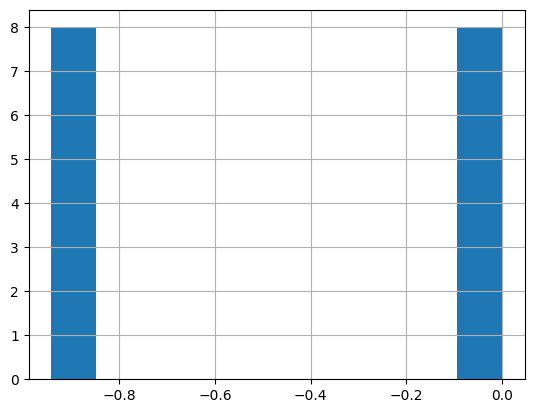

In [39]:
processed_data['EX4']['Screw Speed'].hist()

In [11]:
import matplotlib.pyplot as plt

pressure_timediffs = {}

for col in processed_data['EX1'].columns:

    for ext_num in [1, 2, 3, 4]:        
        extruder = f'EX{ext_num}'
        ex_data = processed_data[extruder][col]

        if col == 'Extruder Pressure':
            pressure_timediffs[extruder] = ex_data.index.to_series().diff()
            break
        
        plt.hist(ex_data.values)
        plt.title(f'{col} for {extruder}')
        plt.show()
    
    break
#    ex_data = processed_data['EX2'][col]
#    plt.hist(ex1_data.values)
#   plt.title(f'{col} for EX1')
#    plt.show()

In [12]:
import matplotlib.pyplot as plt

time_diffs_in_seconds = pressure_timediffs['EX1'].apply(lambda x: x.total_seconds())


In [13]:
time_diffs_in_minutes = time_diffs_in_seconds / 60

In [18]:
max_timediffs = time_diffs_in_minutes.rolling('48H').max()
max_timediffs.name = 'backward looking 48H'

In [19]:
max_timediffs_forward = time_diffs_in_minutes[::-1].rolling('1H').max()
max_timediffs_forward.name = 'forward looking 1H'

In [20]:
test = pd.merge(max_timediffs, max_timediffs_forward, left_index=True, right_index=True, how='outer')

In [21]:
test.head()

,backward looking 48H,forward looking 1H
2023-07-16 04:50:50,NaN,0.066667
2023-07-16 04:50:51,0.016667,0.066667
2023-07-16 04:50:52,0.016667,0.066667
2023-07-16 04:50:53,0.016667,0.066667
2023-07-16 04:50:54,0.016667,0.066667


In [79]:
pressure_timediffs['EX1'].max()

Timedelta('0 days 04:13:15')

In [ ]:
#--------------------functions-----------------------------------------

In [ ]:
import pandas as pd

def merge_data_with_time(
    df, 
    resample_rate='30S', window=None, agg_func='mean', resample_func='max',
    verbose=False, get_series_list=False
):
    """
    Merge data columns with their corresponding time columns in a DataFrame.

    :param df: pandas DataFrame with data and time columns
    :param time_frame: time period for resampling (e.g., '1H' for 1 hour)
    :param agg_func: aggregation function (e.g., 'mean', 'sum', 'max')
    :return: pandas DataFrame after merging
    """
    # Initialize an empty list to store the series
    raw_series_list = []
    processed_series_list = []

    # Determine the aggregation function
    if isinstance(agg_func, str):
        agg_func = getattr(pd.core.groupby.SeriesGroupBy, agg_func)
    if isinstance(agg_func, str):
        resample_func = getattr(pd.core.groupby.SeriesGroupBy, resample_func)

    # Identify and process each data column
    for column in df.columns:
        # Check if the column is a data column (not a time column)
        if not column.endswith('.TIME'):
            # Get the corresponding time column
            time_column = column + '.TIME'

            # Check if the time column exists
            if time_column in df.columns:
                #print(column, time_column)
                # Create a Series with the data column values and time column as index
                series = pd.Series(df[column].values, index=pd.to_datetime(df[time_column]), name=column)
                raw_series_list.append(series)

                #else:
                #    # Group by index (time) and calculate the max for duplicate times
                series = series.groupby(level=0).max()

                if 'PT' in column:
                    local_variance = series.resample(resample_rate).var()
                    local_variance.name = f'{column}_variance'

                if resample_rate:
                    series = series.resample(resample_rate).apply(resample_func)
                if window:
                    series = series.rolling(window=window).apply(agg_func)
                if verbose:
                    print(series.head())    
                processed_series_list.append(series)
                if 'PT' in column:
                    processed_series_list.append(local_variance)

                
    try:
        # Merge all series with an outer join
        merged_df = pd.concat(processed_series_list, axis=1, join='outer')
    except Exception as e:
        print(f'error trying to merge dataframe\nerror: {e}')
        if get_series_list:
            return None, raw_series_list
        else:
            return None

    if get_series_list:
        return merged_df, raw_series_list
    else:
        return merged_df

# Example usage:
# Assume 'dataframe' is your existing DataFrame
# For default behavior
# merged_dataframe = merge_data_with_time(dataframe)

# For resampling every hour and summing values
# merged_dataframe = merge_data_with_time(dataframe, time_frame='1H', agg_func='sum')


In [ ]:
import datetime
from tqdm import tqdm
tqdm.pandas()

def time_until_next_true(bool_series):
    """
    For each datetime index in the series, calculates the time until the next occurrence
    where the series is True.
    
    :param bool_series: A boolean series with a datetime index.
    :return: A series with the time difference until the next True value.
    """
    true_indices = bool_series.index[bool_series]

    def find_time_until_next_true(current_index):
        future_indices = true_indices[true_indices > current_index]
        return future_indices[0] - current_index if not future_indices.empty else pd.NaT

    time_differences = bool_series.index.to_series().progress_apply(find_time_until_next_true)

    return time_differences.apply(lambda x: x.total_seconds() / 3600)

def preprocess_data(df, output_var='Extruder Pressure', output_threshold=5500):
    start_time = datetime.datetime.now()
    processed_df = df.copy()
    print(f'here 0: calculating sample_gap_minutes, time={start_time}')
    processed_df['sample_gap_minutes'] = df.index.to_series().diff().apply(lambda x: x.total_seconds() / 60)
    
    elapsed_str = format_elapsed_time(start_time, datetime.datetime.now())
    print(f'here 1: calculating rolling maxes, elapsed_time={elapsed_str}')
    processed_df['48H_max_gap_backward'] = processed_df['sample_gap_minutes'].rolling('48H').max()
    processed_df['1H_max_gap_forward'] = processed_df[::-1]['sample_gap_minutes'].rolling('1H').max()

    well_sampled_mask = (processed_df['48H_max_gap_backward'] < 15) & (processed_df['1H_max_gap_forward'] < 15)

    elapsed_str = format_elapsed_time(start_time, datetime.datetime.now())
    print(f'here 2: filling forward, elapsed_time={elapsed_str}')

    processed_df = processed_df.fillna(method='ffill')

    processed_df['HAZARD_CONDITION'] = processed_df[output_var] > output_threshold

    hazard_times = processed_df[processed_df['HAZARD_CONDITION']].index

    elapsed_str = format_elapsed_time(start_time, datetime.datetime.now())
    print(f'here 3: calculating time until next hazard region, elapsed_time={elapsed_str}')
    processed_df['hours_to_hazard'] = time_until_next_true(processed_df['HAZARD_CONDITION'])

    #return processed_df
    
    #processed_df['hours_to_hazard'] = processed_df.index.to_series().progress_apply(
    #    lambda x : hours_to_next_pause(x, hazard_times)
    #)

    processed_df['hazard_within_24h'] = processed_df['hours_to_hazard'] < 24

    elapsed_str = format_elapsed_time(start_time, datetime.datetime.now())
    print(f'COMPLETE, elapsed_time={elapsed_str}')

    return processed_df

In [ ]:
def split_dataframe_to_csv(df, rows_per_file, output_prefix):
    """
    Splits a DataFrame into multiple CSV files with a specified number of rows in each.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    rows_per_file (int): The number of rows per each output file.
    output_prefix (str): The prefix for the output file names.
    """
    # Calculate the number of files needed
    num_files = len(df) // rows_per_file + int(len(df) % rows_per_file > 0)

    for i in range(num_files):
        start_row = i * rows_per_file
        end_row = start_row + rows_per_file
        # Slice the DataFrame
        df_slice = df.iloc[start_row:end_row]
        # Save the slice to a CSV file
        df_slice.to_csv(f"{output_prefix}_{i:05d}.csv", index=False)
        print(f"Saved file: {output_prefix}_{i:05d}.csv")

# Example usage
# df = pd.DataFrame(...) # your large DataFrame
# split_dataframe_to_csv(df, 250000, 'output_file')


def format_elapsed_time(start, end):
    """
    Format the elapsed time between two datetime objects into a human-readable string.

    :param start: The start time (datetime object).
    :param end: The end time (datetime object).
    :return: A formatted string representing the elapsed time.
    """
    elapsed = end - start
    days = elapsed.days
    hours, remainder = divmod(elapsed.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    if days > 0:
        return f"{days}d {hours}h {minutes}m {seconds}s"
    elif hours > 0:
        return f"{hours}h {minutes}m {seconds}s"
    elif minutes > 0:
        return f"{minutes}m {seconds}s"
    else:
        return f"{seconds}s"

In [ ]:
#------------------random scribbles----------------------------

In [28]:
test = list(field_mappings[extruder].values())
test.remove('Date and Time')
print(test)

['Extruder Pressure', 'Screw Speed Output', 'Screw Speed', 'Extruder Die Temp', 'Extruder Thrust ', 'Feed Screw Current (Amps)', 'Discharge Conveyor Current (Amps)', 'Discharge Conveyor Speed (%)']


In [41]:
%%time

#inp_filename = 'EX1-6-month.csv'
data_dir = 'data'

field_mappings = {}
#time_
ex_data = {}
processed_data = {}
collected_series = {}

for extruder in ['EX1', 'EX2', 'EX3', 'EX4']:
    print(extruder)
    ex_name_mapping = pd.read_csv(os.path.join(data_dir, f'{extruder}-6-month.csv'), 
                               delimiter='\t',
                               encoding='utf-16',
                               nrows=1)

    field_mappings[extruder] = dict(zip(ex_name_mapping.iloc[0], ex_name_mapping.columns ))
    

    #print(extruder)
    #print(name_mappings[extruder])


   # for field_key in name_mappings[extruder]:

    col_mapping = {key : key.split(' (')[0] for key, value in field_mappings[extruder].items() if key != 'Time'}

#    for raw_colname in col_mapping.keys():
#        field_mappings[extruder + '_col2col'] = 

    field_mappings[extruder + '_column_map'] = col_mapping
    
    raw_fieldnames = sorted(col_mapping.values())
    time_keys = [fieldname + '.TIME' for fieldname in raw_fieldnames]
        
    #print(keys_filtered)
    #print(time_keys)

    keys_of_interest = sorted(raw_fieldnames + time_keys)

    ex_data[extruder] = raw_data[keys_of_interest]

    processed_df, series_list = merge_data_with_time(
        ex_data[extruder], verbose=False, window=None, get_series_list=True
    )

    for raw_colname in col_mapping.keys():
        processed_df[field_mappings[extruder][raw_colname]] = processed_df[field_mappings[f'{extruder}_column_map'][raw_colname]]
        
    processed_colnames = list(field_mappings[extruder].values())
    processed_colnames.remove('Date and Time')
    processed_df = processed_df[processed_colnames]
    
    processed_data[extruder] = processed_df
    collected_series[extruder] = series_list
    
    for tk in time_keys:
        ex_data[extruder][tk] = pd.to_datetime(ex_data[extruder][tk])

        field_key = tk.replace('.TIME', '')

    print()
    #ex_data[extruder] = raw_data[keys_filtered]

EX1

EX2

EX3

EX4

CPU times: user 1min 46s, sys: 7.15 s, total: 1min 53s
Wall time: 1min 53s


In [42]:
processed_data['EX1'].head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:50,4070.291016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 04:50:51,3941.896484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 04:50:52,4167.226562,NaN,NaN,NaN,NaN,NaN,0.94,NaN
2023-07-16 04:50:53,3930.353516,NaN,NaN,NaN,49.097092,NaN,0.98,NaN
2023-07-16 04:50:54,4192.916016,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
for col in processed_data['EX1'].columns:
    print(col)
    print(processed_data['EX1'][processed_data['EX1'][col].notnull()].index.min())

Extruder Pressure
2023-07-16 04:50:50
Screw Speed Output
2023-07-16 09:19:27
Screw Speed
2023-07-17 16:06:15
Extruder Die Temp
2023-07-16 05:23:22
Extruder Thrust 
2023-07-16 04:50:53
Feed Screw Current (Amps)
2023-07-16 04:51:02
Discharge Conveyor Current (Amps)
2023-07-16 04:50:52
Discharge Conveyor Speed (%)
2023-07-17 16:06:18


In [12]:
ex_name_mapping

,Date and Time,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
0,Time,PT_5362.PV (psi),SIC_5360.OUT (%),ST_5362.PV (RPM),TT_5362.PV (°F),WT_5362.PV (%),PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.I...,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.I...,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.S...


In [18]:
field_mappings

{'EX1': {'Time': 'Date and Time',
  'PT_5347.PV (psi)': 'Extruder Pressure',
  'ST_5347.PV (RPM)': 'Screw Speed Output',
  'SIC_5345.OUT (%)': 'Screw Speed',
  'TT_5347.PV (°F)': 'Extruder Die Temp',
  'WT_5347.PV (%)': 'Extruder Thrust ',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'Feed Screw Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'Discharge Conveyor Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT (%)': 'Discharge Conveyor Speed (%)'},
 'EX1_column_map': {'PT_5347.PV (psi)': 'PT_5347.PV',
  'ST_5347.PV (RPM)': 'ST_5347.PV',
  'SIC_5345.OUT (%)': 'SIC_5345.OUT',
  'TT_5347.PV (°F)': 'TT_5347.PV',
  'WT_5347.PV (%)': 'WT_5347.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV',
  'PJ00

In [13]:
processed_data['EX4'].head(1)

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT,PT_5362.PV,SIC_5360.OUT,ST_5362.PV,TT_5362.PV,WT_5362.PV
2023-07-16 04:50:00,3.41,1.07,NaN,1801.763074,NaN,NaN,NaN,37.122286


In [17]:
for ex in processed_data.keys():
    processed_df = processed_data[ex]
    print(ex)
    print(processed_df.isnull().sum()/len(processed_df))
    #print(processed_data[ex].head(1))
    print()

In [11]:
field_mappings

{'EX1': {'Time': 'Date and Time',
  'PT_5347.PV (psi)': 'Extruder Pressure',
  'ST_5347.PV (RPM)': 'Screw Speed Output',
  'SIC_5345.OUT (%)': 'Screw Speed',
  'TT_5347.PV (°F)': 'Extruder Die Temp',
  'WT_5347.PV (%)': 'Extruder Thrust ',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'Feed Screw Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'Discharge Conveyor Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT (%)': 'Discharge Conveyor Speed (%)'},
 'EX1_column_map': {'PT_5347.PV (psi)': 'PT_5347.PV',
  'ST_5347.PV (RPM)': 'ST_5347.PV',
  'SIC_5345.OUT (%)': 'SIC_5345.OUT',
  'TT_5347.PV (°F)': 'TT_5347.PV',
  'WT_5347.PV (%)': 'WT_5347.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV',
  'PJ00

In [73]:
test = processed_df[processed_df['ST_5347.PV'].notnull()]
test.sort_index().index[:50]

DatetimeIndex(['2023-07-16 09:19:00', '2023-07-16 17:09:00',
               '2023-07-17 01:00:00', '2023-07-17 08:50:00',
               '2023-07-17 16:05:00', '2023-07-17 16:06:00',
               '2023-07-17 16:07:00', '2023-07-17 23:58:00',
               '2023-07-18 07:48:00', '2023-07-18 15:38:00',
               '2023-07-18 23:29:00', '2023-07-19 07:19:00',
               '2023-07-19 15:10:00', '2023-07-19 23:00:00',
               '2023-07-20 06:50:00', '2023-07-20 11:09:00',
               '2023-07-20 12:29:00', '2023-07-20 12:30:00',
               '2023-07-20 20:20:00', '2023-07-21 04:10:00',
               '2023-07-21 12:01:00', '2023-07-21 19:51:00',
               '2023-07-22 03:41:00', '2023-07-22 11:32:00',
               '2023-07-22 19:22:00', '2023-07-23 03:13:00',
               '2023-07-23 11:03:00', '2023-07-23 18:53:00',
               '2023-07-24 02:44:00', '2023-07-24 10:34:00',
               '2023-07-24 18:25:00', '2023-07-25 02:15:00',
               '2023-07-

In [75]:
test.head(5)

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,PT_5347.PV,SIC_5345.OUT,ST_5347.PV,TT_5347.PV,WT_5347.PV
2023-07-16 09:19:00,2.7350,0.970741,NaN,4067.157785,NaN,27.800705,NaN,48.920944
2023-07-16 17:09:00,2.7550,0.947826,NaN,4107.848800,NaN,27.796013,NaN,50.515979
2023-07-17 01:00:00,NaN,0.985714,NaN,4229.140625,NaN,27.820351,NaN,51.048469
2023-07-17 08:50:00,5.7975,0.967391,NaN,4159.743207,NaN,27.828751,NaN,50.613756
2023-07-17 16:05:00,NaN,0.946667,NaN,4411.497389,NaN,27.822044,350.408203,50.505443


In [30]:
field_mappings

{'EX1': {'Time': 'Date and Time',
  'PT_5347.PV (psi)': 'Extruder Pressure',
  'ST_5347.PV (RPM)': 'Screw Speed Output',
  'SIC_5345.OUT (%)': 'Screw Speed',
  'TT_5347.PV (°F)': 'Extruder Die Temp',
  'WT_5347.PV (%)': 'Extruder Thrust ',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'Feed Screw Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'Discharge Conveyor Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT (%)': 'Discharge Conveyor Speed (%)'},
 'EX1_column_map': {'PT_5347.PV (psi)': 'PT_5347.PV',
  'ST_5347.PV (RPM)': 'ST_5347.PV',
  'SIC_5345.OUT (%)': 'SIC_5345.OUT',
  'TT_5347.PV (°F)': 'TT_5347.PV',
  'WT_5347.PV (%)': 'WT_5347.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV',
  'PJ00

In [ ]:
for col in processed_data['EX1'].columns:
    print(f'{col}')


In [67]:
(processed_data['EX1'] == 0).sum()

Extruder Pressure                        8
Screw Speed Output                       8
Screw Speed                              1
Extruder Die Temp                        8
Extruder Thrust                          8
Feed Screw Current (Amps)            33294
Discharge Conveyor Current (Amps)       41
Discharge Conveyor Speed (%)             1
dtype: int64

In [68]:
(processed_data['EX2'] == 0).sum()

Extruder Pressure                        8
Screw Speed Output                       1
Screw Speed                              8
Extruder Die Temp                        8
Extruder Thrust                          8
Feed Screw Current (Amps)            35246
Discharge Conveyor Current (Amps)       28
Discharge Conveyor Speed (%)             1
dtype: int64

In [69]:
(processed_data['EX3'] == 0).sum()

Extruder Pressure                        6
Screw Speed Output                       1
Screw Speed                              6
Extruder Die Temp                        6
Extruder Thrust                          6
Feed Screw Current (Amps)            34330
Discharge Conveyor Current (Amps)       27
Discharge Conveyor Speed (%)             1
dtype: int64

In [70]:
(processed_data['EX4'] == 0).sum()

Extruder Pressure                        8
Screw Speed Output                       1
Screw Speed                              1
Extruder Die Temp                        8
Extruder Thrust                          7
Feed Screw Current (Amps)            28727
Discharge Conveyor Current (Amps)     1222
Discharge Conveyor Speed (%)             1
dtype: int64

In [71]:
processed_data['EX1'][processed_data['EX1']['Extruder Pressure'] == 0]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-17 16:06:15,0.0,0.0,6.952558e-310,NaN,NaN,0.0,0.0,NaN
2023-09-05 07:01:12,0.0,0.0,6.952558e-310,0.0,NaN,0.0,0.0,NaN
2023-09-23 08:02:39,0.0,0.0,6.952558e-310,0.0,NaN,0.0,0.0,6.952558e-310
2023-10-03 18:24:53,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2023-11-07 06:30:00,0.0,0.0,6.952558e-310,0.0,0.0,0.0,0.0,NaN
2023-11-23 07:59:47,0.0,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310
2024-01-12 17:09:19,0.0,0.0,6.952558e-310,0.0,0.0,0.0,0.0,NaN
2024-01-12 17:40:25,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,NaN


In [72]:
processed_data['EX2'][processed_data['EX2']['Extruder Pressure'] == 0]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-17 16:06:15,0.0,6.952558e-310,0.0,NaN,NaN,0.0,0.000000e+00,NaN
2023-09-05 07:01:12,0.0,6.952558e-310,0.0,0.0,NaN,0.0,0.000000e+00,NaN
2023-09-23 08:02:39,0.0,6.952558e-310,0.0,0.0,NaN,0.0,0.000000e+00,6.952558e-310
2023-10-03 18:24:53,0.0,NaN,0.0,0.0,0.0,0.0,0.000000e+00,NaN
2023-11-07 06:30:00,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310,NaN
2023-11-23 07:59:47,0.0,6.952558e-310,0.0,0.0,0.0,0.0,0.000000e+00,6.952558e-310
2024-01-12 17:09:19,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310,NaN
2024-01-12 17:40:25,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,NaN


In [73]:
processed_data['EX3'][processed_data['EX3']['Extruder Pressure'] == 0]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-09-23 08:02:39,0.0,6.952558e-310,0.0,0.0,NaN,0.000000e+00,0.0,6.952558e-310
2023-10-03 18:24:53,0.0,NaN,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2023-11-07 06:30:00,0.0,6.952558e-310,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2023-11-23 07:59:47,0.0,6.952558e-310,0.0,0.0,0.0,6.952558e-310,0.0,6.952558e-310
2024-01-12 17:09:19,0.0,6.952558e-310,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2024-01-12 17:40:25,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,NaN


In [74]:
processed_data['EX4'][processed_data['EX4']['Extruder Pressure'] == 0]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-17 16:06:15,0.0,6.952558e-310,6.952558e-310,NaN,NaN,0.0,0.0,NaN
2023-09-05 07:01:12,0.0,6.952558e-310,6.952558e-310,0.0,NaN,0.0,0.0,NaN
2023-09-23 08:02:39,0.0,6.952558e-310,6.952558e-310,0.0,NaN,0.0,0.0,6.952558e-310
2023-10-03 18:24:53,0.0,NaN,6.952558e-310,0.0,0.000000e+00,0.0,0.0,NaN
2023-11-07 06:30:00,0.0,6.952558e-310,6.952558e-310,0.0,0.000000e+00,0.0,0.0,NaN
2023-11-23 07:59:47,0.0,6.952558e-310,6.952558e-310,0.0,0.000000e+00,0.0,0.0,6.952558e-310
2024-01-12 17:09:19,0.0,6.952558e-310,6.952558e-310,0.0,6.952558e-310,0.0,0.0,NaN
2024-01-12 17:40:25,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,NaN


In [30]:
ex_data['EX1'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT.TIME,PT_5347.PV,PT_5347.PV.TIME,SIC_5345.OUT,SIC_5345.OUT.TIME,ST_5347.PV,ST_5347.PV.TIME,TT_5347.PV,TT_5347.PV.TIME,WT_5347.PV,WT_5347.PV.TIME
0,5.56,2023-07-16 04:51:02,0.94,2023-07-16 04:50:52,6.952558e-310,2023-07-17 16:06:18,4070.291016,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:15,27.800705,2023-07-16 09:19:27,334.851562,2023-07-16 05:23:22,49.097092,2023-07-16 04:50:53
1,0.00,2023-07-16 04:51:03,0.98,2023-07-16 04:50:53,7.000000e+01,2023-07-17 16:07:48,3941.896484,2023-07-16 04:50:51,3.500000e+01,2023-07-17 16:07:46,27.796013,2023-07-16 17:09:49,335.320312,2023-07-16 06:17:56,48.470383,2023-07-16 04:50:56
2,5.34,2023-07-16 04:53:45,0.96,2023-07-16 04:50:55,8.500000e+01,2023-08-03 09:32:37,4167.226562,2023-07-16 04:50:52,2.500000e+01,2023-07-25 14:28:38,27.820351,2023-07-17 01:00:20,337.341797,2023-07-16 07:31:15,48.842682,2023-07-16 04:51:09
3,5.57,2023-07-16 04:53:47,1.02,2023-07-16 04:50:56,1.000000e+02,2023-08-03 09:51:02,3930.353516,2023-07-16 04:50:53,NaN,NaT,27.828751,2023-07-17 08:50:49,341.666016,2023-07-16 10:29:42,48.621353,2023-07-16 04:51:22
4,5.51,2023-07-16 04:55:14,1.01,2023-07-16 04:50:57,NaN,NaT,4192.916016,2023-07-16 04:50:54,NaN,NaT,27.822044,2023-07-17 16:05:54,344.843750,2023-07-16 11:05:26,48.816040,2023-07-16 04:51:35


In [31]:
ex_data['EX1'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT.TIME,PT_5347.PV,PT_5347.PV.TIME,SIC_5345.OUT,SIC_5345.OUT.TIME,ST_5347.PV,ST_5347.PV.TIME,TT_5347.PV,TT_5347.PV.TIME,WT_5347.PV,WT_5347.PV.TIME
0,5.56,2023-07-16 04:51:02,0.94,2023-07-16 04:50:52,6.952558e-310,2023-07-17 16:06:18,4070.291016,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:15,27.800705,2023-07-16 09:19:27,334.851562,2023-07-16 05:23:22,49.097092,2023-07-16 04:50:53
1,0.00,2023-07-16 04:51:03,0.98,2023-07-16 04:50:53,7.000000e+01,2023-07-17 16:07:48,3941.896484,2023-07-16 04:50:51,3.500000e+01,2023-07-17 16:07:46,27.796013,2023-07-16 17:09:49,335.320312,2023-07-16 06:17:56,48.470383,2023-07-16 04:50:56
2,5.34,2023-07-16 04:53:45,0.96,2023-07-16 04:50:55,8.500000e+01,2023-08-03 09:32:37,4167.226562,2023-07-16 04:50:52,2.500000e+01,2023-07-25 14:28:38,27.820351,2023-07-17 01:00:20,337.341797,2023-07-16 07:31:15,48.842682,2023-07-16 04:51:09
3,5.57,2023-07-16 04:53:47,1.02,2023-07-16 04:50:56,1.000000e+02,2023-08-03 09:51:02,3930.353516,2023-07-16 04:50:53,NaN,NaT,27.828751,2023-07-17 08:50:49,341.666016,2023-07-16 10:29:42,48.621353,2023-07-16 04:51:22
4,5.51,2023-07-16 04:55:14,1.01,2023-07-16 04:50:57,NaN,NaT,4192.916016,2023-07-16 04:50:54,NaN,NaT,27.822044,2023-07-17 16:05:54,344.843750,2023-07-16 11:05:26,48.816040,2023-07-16 04:51:35


In [32]:
ex_data['EX1'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12505849 entries, 0 to 12505848
Data columns (total 16 columns):
 #   Column                                                          Dtype         
---  ------                                                          -----         
 0   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV         float64       
 1   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV.TIME    datetime64[ns]
 2   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV         float64       
 3   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV.TIME    datetime64[ns]
 4   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT       float64       
 5   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT.TIME  datetime64[ns]
 6   PT_5347.PV                                                      float64       
 7   PT_5347.PV.TIME                                                 datetime64[ns]
 8   SIC_5345.OUT                            

In [33]:
ex_data['EX2'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT.TIME,PT_5352.PV,PT_5352.PV.TIME,SIC_5350.OUT,SIC_5350.OUT.TIME,ST_5352.PV,ST_5352.PV.TIME,TT_5352.PV,TT_5352.PV.TIME,WT_5352.PV,WT_5352.PV.TIME
0,5.66,2023-07-16 04:53:10,0.98,2023-07-16 04:53:18,6.952558e-310,2023-07-17 16:06:18,3206.291016,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:15,27.813858,2023-07-16 05:32:47,272.890625,2023-07-16 04:55:17,59.686783,2023-07-16 04:50:55
1,4.74,2023-07-16 04:53:11,0.97,2023-07-16 04:54:57,8.000000e+01,2023-07-17 16:07:48,3055.000000,2023-07-16 04:50:52,3.500000e+01,2023-07-17 16:07:46,27.783119,2023-07-16 13:29:18,274.255859,2023-07-16 05:02:58,59.433762,2023-07-16 04:51:11
2,4.70,2023-07-16 04:58:38,0.99,2023-07-16 04:54:59,8.500000e+01,2023-08-03 09:32:47,3165.830078,2023-07-16 04:50:53,2.500000e+01,2023-07-25 14:28:25,27.758209,2023-07-16 21:26:34,276.605469,2023-07-16 05:18:32,60.262482,2023-07-16 04:51:14
3,5.35,2023-07-16 04:58:40,0.98,2023-07-16 04:55:10,NaN,NaT,3026.894531,2023-07-16 04:50:54,5.000000e+01,2023-07-25 14:47:16,27.752220,2023-07-17 05:24:09,274.621094,2023-07-16 05:26:59,59.789719,2023-07-16 04:51:18
4,0.00,2023-07-16 04:58:41,0.98,2023-07-16 05:03:59,NaN,NaT,3201.855469,2023-07-16 04:50:55,1.000000e+02,2023-07-25 14:47:26,27.781960,2023-07-17 12:03:19,275.726562,2023-07-16 05:33:03,59.664200,2023-07-16 04:51:50


In [34]:
ex_data['EX3'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5355.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5355.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5415.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5415.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5415.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5415.OUT.TIME,PT_5357.PV,PT_5357.PV.TIME,SIC_5355.OUT,SIC_5355.OUT.TIME,ST_5357.PV,ST_5357.PV.TIME,TT_5357.PV,TT_5357.PV.TIME,WT_5357.PV,WT_5357.PV.TIME
0,6.952558e-310,2023-07-17 16:06:15,0.04,2023-07-17 15:36:23,6.952558e-310,2023-07-17 16:06:18,6.952558e-310,2023-07-17 16:06:15,6.952558e-310,2023-07-17 16:06:15,6.952558e-310,2023-07-17 16:06:15,6.952558e-310,2023-07-17 16:06:27,6.952558e-310,2023-07-17 16:06:27
1,0.000000e+00,2023-07-17 16:07:46,0.07,2023-07-17 15:36:24,8.000000e+01,2023-07-17 16:07:48,-2.718750e+02,2023-07-17 16:07:46,3.000000e+01,2023-07-17 16:07:46,-9.425001e-01,2023-07-17 16:07:46,-1.450000e+01,2023-07-17 16:07:46,-3.625000e+00,2023-07-17 16:07:46
2,NaN,NaT,0.00,2023-07-17 15:36:46,NaN,NaT,NaN,NaT,2.500000e+01,2023-07-25 14:28:06,NaN,NaT,NaN,NaT,NaN,NaT
3,NaN,NaT,0.07,2023-07-17 15:36:52,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
4,NaN,NaT,0.08,2023-07-17 15:45:49,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT


In [35]:
ex_data['EX4'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT.TIME,PT_5362.PV,PT_5362.PV.TIME,SIC_5360.OUT,SIC_5360.OUT.TIME,ST_5362.PV,ST_5362.PV.TIME,TT_5362.PV,TT_5362.PV.TIME,WT_5362.PV,WT_5362.PV.TIME
0,4.99,2023-07-16 04:51:39,1.07,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:18,1799.374023,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:15,6.952558e-310,2023-07-17 16:06:15,8.323669,2023-07-16 05:04:36,37.652023,2023-07-16 04:50:50
1,5.24,2023-07-16 04:51:40,1.03,2023-07-16 04:50:52,7.000000e+01,2023-07-17 16:07:48,1746.228516,2023-07-16 04:50:51,7.500000e+01,2023-07-17 16:07:46,-9.425001e-01,2023-07-17 16:07:46,8.873474,2023-07-16 12:55:00,36.429214,2023-07-16 04:50:51
2,0.00,2023-07-16 04:51:41,1.10,2023-07-16 04:50:56,1.000000e+02,2023-07-20 12:09:44,1824.406250,2023-07-16 04:50:52,2.500000e+01,2023-07-25 14:27:40,NaN,NaT,8.811279,2023-07-16 20:45:25,37.902496,2023-07-16 04:50:52
3,6.53,2023-07-16 04:56:10,1.04,2023-07-16 04:51:00,7.000000e+01,2023-07-20 12:13:20,1758.250000,2023-07-16 04:50:53,3.500000e+01,2023-07-29 05:38:22,NaN,NaT,8.643921,2023-07-17 04:35:50,36.522247,2023-07-16 04:50:53
4,5.34,2023-07-16 04:56:11,1.08,2023-07-16 04:51:01,8.000000e+01,2023-07-24 14:09:02,1842.168945,2023-07-16 04:50:55,NaN,NaT,NaN,NaT,8.886841,2023-07-17 12:26:13,37.670731,2023-07-16 04:50:54


In [36]:
print(processed_data['EX1'].info())
processed_data['EX1'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52417 entries, 2023-07-16 04:50:00 to 2024-01-14 04:50:00
Freq: 5T
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Extruder Pressure                  51895 non-null  float64
 1   Screw Speed Output                 734 non-null    float64
 2   Screw Speed                        16 non-null     float64
 3   Extruder Die Temp                  7149 non-null   float64
 4   Extruder Thrust                    51816 non-null  float64
 5   Feed Screw Current (Amps)          51856 non-null  float64
 6   Discharge Conveyor Current (Amps)  37985 non-null  float64
 7   Discharge Conveyor Speed (%)       19 non-null     float64
dtypes: float64(8)
memory usage: 3.6 MB
None


,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:00,4057.106586,NaN,NaN,NaN,48.796735,4.1175,0.969687,NaN
2023-07-16 04:55:00,3996.547541,NaN,NaN,NaN,48.589401,4.9770,0.976985,NaN
2023-07-16 05:00:00,3998.819069,NaN,NaN,NaN,48.614656,3.8300,0.971379,NaN
2023-07-16 05:05:00,4076.056384,NaN,NaN,NaN,49.006142,3.6900,0.971888,NaN
2023-07-16 05:10:00,4133.956836,NaN,NaN,NaN,49.074539,4.5060,0.970986,NaN


In [37]:
print(processed_data['EX2'].info())
processed_data['EX2'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52417 entries, 2023-07-16 04:50:00 to 2024-01-14 04:50:00
Freq: 5T
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Extruder Pressure                  49288 non-null  float64
 1   Screw Speed Output                 29 non-null     float64
 2   Screw Speed                        1474 non-null   float64
 3   Extruder Die Temp                  7849 non-null   float64
 4   Extruder Thrust                    49277 non-null  float64
 5   Feed Screw Current (Amps)          46429 non-null  float64
 6   Discharge Conveyor Current (Amps)  16380 non-null  float64
 7   Discharge Conveyor Speed (%)       18 non-null     float64
dtypes: float64(8)
memory usage: 3.6 MB
None


,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:00,3221.500208,NaN,NaN,NaN,60.076366,5.200,0.980000,NaN
2023-07-16 04:55:00,3147.111020,NaN,NaN,272.890625,59.512808,3.350,0.980000,NaN
2023-07-16 05:00:00,3217.413433,NaN,NaN,274.255859,59.979941,4.710,0.995000,NaN
2023-07-16 05:05:00,3310.032572,NaN,NaN,NaN,60.364799,3.550,0.984286,NaN
2023-07-16 05:10:00,3292.845131,NaN,NaN,NaN,60.667564,2.345,0.975000,NaN


In [38]:
print(processed_data['EX3'].info())
processed_data['EX3'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52000 entries, 2023-07-17 15:35:00 to 2024-01-14 04:50:00
Freq: 5T
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Extruder Pressure                  32081 non-null  float64
 1   Screw Speed Output                 16 non-null     float64
 2   Screw Speed                        611 non-null    float64
 3   Extruder Die Temp                  364 non-null    float64
 4   Extruder Thrust                    32074 non-null  float64
 5   Feed Screw Current (Amps)          31614 non-null  float64
 6   Discharge Conveyor Current (Amps)  3961 non-null   float64
 7   Discharge Conveyor Speed (%)       16 non-null     float64
dtypes: float64(8)
memory usage: 3.6 MB
None


,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-17 15:35:00,NaN,NaN,NaN,NaN,NaN,NaN,0.045,NaN
2023-07-17 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-17 15:45:00,NaN,NaN,NaN,NaN,NaN,NaN,0.040,NaN
2023-07-17 15:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-17 15:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
print(processed_data['EX4'].info())
processed_data['EX4'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52417 entries, 2023-07-16 04:50:00 to 2024-01-14 04:50:00
Freq: 5T
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Extruder Pressure                  50140 non-null  float64
 1   Screw Speed Output                 36 non-null     float64
 2   Screw Speed                        13 non-null     float64
 3   Extruder Die Temp                  878 non-null    float64
 4   Extruder Thrust                    43990 non-null  float64
 5   Feed Screw Current (Amps)          46559 non-null  float64
 6   Discharge Conveyor Current (Amps)  41932 non-null  float64
 7   Discharge Conveyor Speed (%)       38 non-null     float64
dtypes: float64(8)
memory usage: 3.6 MB
None


,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:00,1801.763074,NaN,NaN,NaN,37.122286,3.410000,1.070000,NaN
2023-07-16 04:55:00,1792.386690,NaN,NaN,NaN,37.019737,4.675000,1.070756,NaN
2023-07-16 05:00:00,1805.653592,NaN,NaN,8.323669,37.135512,4.131667,1.067364,NaN
2023-07-16 05:05:00,1787.643932,NaN,NaN,NaN,36.980019,5.272500,1.069709,NaN
2023-07-16 05:10:00,1789.340884,NaN,NaN,NaN,37.037894,3.772500,1.071493,NaN


In [17]:
ex1_field_mapping = 

In [18]:
ex1_field_mapping

{'Time': 'Date and Time',
 'PT_5347.PV (psi)': 'Extruder Pressure',
 'ST_5347.PV (RPM)': 'Screw Speed Output',
 'SIC_5345.OUT (%)': 'Screw Speed',
 'TT_5347.PV (°F)': 'Extruder Die Temp',
 'WT_5347.PV (%)': 'Extruder Thrust ',
 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'Feed Screw Current (Amps)',
 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'Discharge Conveyor Current (Amps)',
 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT (%)': 'Discharge Conveyor Speed (%)'}

In [10]:
ex1_code_names = ex1_raw_data.iloc[0]
ex1_raw_data = ex1_raw_data.iloc[1:]

#test = ex1_raw_data.infer_objects()

#for types in zip(ex1_raw_data.dtypes, test.dtypes):
#    print(types)

ex1_raw_data.dtypes



NameError: name 'ex1_raw_data' is not defined

In [ ]:
ex1_raw_data.head(2)

In [ ]:
ex1_raw_data.info()

In [ ]:
has_null_vals = ex1_raw_data.apply(lambda row: '<null>' in row.values, axis=1)

In [ ]:
ex1_raw_data.iloc[0]

In [ ]:
test = ex1_raw_data[has_null_vals]

In [ ]:
len(t)

In [ ]:
for t in test.columns:
    print(test[t].value_counts())